## Image Focus and Astigmatism Classifier
**Author:** [Aaron Woods](https://aaronwoods.info)  
**Date Created:** September 21, 2023  
**Description:** This script provides an end-to-end machine learning pipeline to classify images as either "In Focus" or "Out of Focus", and additionally identifies astigmatism-related issues.  
**Repository:** [Image Classification on VSCode](https://insiders.vscode.dev/tunnel/midnightsim/c:/Users/User/Desktop/Image-Classification)

### Overview
The script features a comprehensive pipeline that ingests data from Excel spreadsheets and feeds it into various machine learning models. The design is modular, allowing for easy adaptability to address different image classification problems, including focus quality and astigmatism detection.


## Setup

In [15]:
# ------------------------------
# TensorFlow Installation with GPU Support
# ------------------------------
# Note: TensorFlow versions above 2.10 are not supported on GPUs on native Windows installations.
# For more details, visit: https://www.tensorflow.org/install/pip#windows-wsl2_1

# Uncomment the following line to install TensorFlow if needed.
%pip install "tensorflow<2.11" --user

# ------------------------------
# System and TensorFlow Info Check
# ------------------------------
# Import necessary libraries and initialize an empty dictionary to store system information.
import platform
system_info = {"Platform": platform.platform(), "Python Version": platform.python_version()}

# Try importing TensorFlow and collecting relevant system information.
try:
    import tensorflow as tf
    system_info.update({
        "TensorFlow Version": tf.__version__,
        "Num GPUs Available": len(tf.config.list_physical_devices('GPU'))
    })
    system_info['Instructions'] = (
        "You're all set to run your model on a GPU." 
        if system_info['Num GPUs Available'] 
        else (
            "No GPUs found. To use a GPU, follow these steps:\n"
            "  1. Install NVIDIA drivers for your GPU.\n"
            "  2. Install a compatible CUDA toolkit.\n"
            "  3. Install the cuDNN library.\n"
            "  4. Make sure to install the GPU version of TensorFlow."
        )
    )
except ModuleNotFoundError:
    system_info['Instructions'] = (
        "TensorFlow is not installed. "
        "Install it using pip by running: !pip install tensorflow"
    )

# Format and display the gathered system information.
formatted_info = "\n".join(f"{key}: {value}" for key, value in system_info.items())
print(formatted_info)



Note: you may need to restart the kernel to use updated packages.
Platform: Windows-10-10.0.17763-SP0
Python Version: 3.9.18
TensorFlow Version: 2.10.1
Num GPUs Available: 1
Instructions: You're all set to run your model on a GPU.


In [16]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)
    
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [17]:
!pip install opencv-python numpy pandas matplotlib protobuf seaborn scikit-learn openpyxl


In [18]:
# ------------------------------
# Package Installation (Optional)
# ------------------------------
# Uncomment the following lines to install required packages if running on a new machine.
# To suppress the output, we use '> /dev/null 2>&1'.

# ------------------------------
# Import Libraries
# ------------------------------

# Standard Libraries
import os, sys, random, math, glob, logging
from datetime import datetime
from collections import defaultdict

# Third-Party Libraries
import numpy as np
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from sklearn.utils.class_weight import compute_class_weight
from IPython.display import clear_output
from collections import Counter
from sklearn.preprocessing import LabelEncoder, MultiLabelBinarizer

# TensorFlow and Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.metrics import Precision, Recall, AUC
from tensorflow.keras.callbacks import TensorBoard, Callback
from tensorflow.keras.applications import InceptionV3, ResNet50
from keras.models import load_model
from tensorflow.data import Dataset

import pickle

# Type Annotations
from typing import List, Dict, Tuple, Union, Any, Optional


## Configuration

In [19]:
# Configuration dictionary
config = {
    'Experiment': {
        'NAME': "DOE_v1_SIM_noclw",  # Experiment name
        'RANDOM_SEED': 42,  # Seed for reproducibility
        'PROBLEM_TYPE': 'Multi-Output',  # Problem type: Binary, Multi-Class, Multi-Output, Multi-Label
    },
    'Model': {
        'IMG_SIZE': 224,  # Image input size
        'BATCH_SIZE': 16,  # Batch size for training
        'TRAIN_SIZE': 0.8,  # Fraction of data to use for training
        'VAL_SIZE': 0.5,  # Fraction of data to use for validation
        'EPOCHS': 100,  # Number of training epochs
        'LEARNING_RATE': 0.001,  # Learning rate 1e-3
        'EARLY_STOPPING_PATIENCE': 50,  # Early stopping patience
        'REDUCE_LR_PATIENCE':3,  # Reduce learning rate on plateau patience
        'MIN_LR': 1e-6,  # Minimum learning rate
    },
    'Labels': {
        'MAPPINGS': {  # Class label mappings
            'Focus_Label': {'SharpFocus': 0, 'SlightlyBlurred': 1, 'HighlyBlurred': 2},
            'StigX_Label': {'OptimalStig_X': 0, 'ModerateStig_X': 1, 'SevereStig_X': 2},
            'StigY_Label': {'OptimalStig_Y': 0, 'ModerateStig_Y': 1, 'SevereStig_Y': 2},
        }
    },
    'Augmentation': {  # Data augmentation parameters
        'rotation_factor': 0.002,
        'height_factor': (-0.18, 0.18),
        'width_factor': (-0.18, 0.18),
        'contrast_factor': 0.5,
    }
}


In [20]:
# Configure for dataset creation

csv_config = {
    'CSV': {
        'COLUMNS_TO_READ': ['ImageFile', 'Focus_Offset (V)', 'Stig_Offset_X (V)', 'Stig_Offset_Y (V)']
    },
    'Thresholds': {
        'FOCUS_LOW': 30,  # Lower focus threshold
        'FOCUS_HIGH': 60,  # Upper focus threshold
        'STIGX_LOW': 1,  # Lower astigmatism threshold
        'STIGX_HIGH': 2,  # Upper astigmatism threshold
        'STIGY_LOW': 1,  # Lower astigmatism threshold
        'STIGY_HIGH': 2,  # Upper astigmatism threshold
    },
    'Paths': {  # Data and model paths
        'DATA_FILE': "combined_output.csv",
        # 'DATA_FILE': "combined_output_cleaned.csv",
        'OLD_BASE_PATH': "D:\\DOE\\",
        'NEW_BASE_PATH': "Y:\\User\\Aaron-HX38\\DOE\\", # On Simulation Computer
        # 'NEW_BASE_PATH': "C:\\Users\\aaron.woods\\OneDrive - Thermo Fisher Scientific\\Desktop\\Dec 24\\",
    },
    'SAMPLE_FRAC': 1,  # Fraction of the data to use for quicker prototyping. 1.0 means use all data.
}
config.update(csv_config)


In [21]:
# Set random seed for reproducibility
np.random.seed(config['Experiment']['RANDOM_SEED'])
tf.random.set_seed(config['Experiment']['RANDOM_SEED'])

## Load and Preprocess the data

### Functions for Preparation of CSV

In [22]:
# Read the data

def read_csv(config: Dict):
    # Functionality to read the data
    data_file_path = os.path.join(config['Paths']['NEW_BASE_PATH'], config['Paths']['DATA_FILE'])
    if not os.path.exists(data_file_path):
        raise FileNotFoundError(f"Error: File does not exist - {data_file_path}")
    try:
        data = pd.read_csv(data_file_path, usecols=config['CSV']['COLUMNS_TO_READ'])
        print("---> Data read successfully.")
        sample_frac = config.get('SAMPLE_FRAC', 1.0)
        if 0 < sample_frac < 1.0:
            data = data.sample(frac=sample_frac).reset_index(drop=True)
            print(f"---> Data sampled: Using {sample_frac * 100}% of the available data.")
    except Exception as e:
        raise ValueError(f"Error: Could not read data - {e}") from e
    return data

def update_image_paths(df):
    old_base_path = config['Paths']['OLD_BASE_PATH']
    new_base_path = config['Paths']['NEW_BASE_PATH']
    df['ImageFile'] = df['ImageFile'].str.replace(old_base_path, new_base_path, regex=False)
    print("---> Image paths updated.")
    return df


def clean_csv(df: pd.DataFrame, save_cleaned: bool = False) -> pd.DataFrame:
    def is_valid_string(image_path) -> bool:
        return isinstance(image_path, str)
    
    def does_file_exist(image_path) -> bool:
        return os.path.exists(image_path)
    
    def can_image_be_read(image_path) -> bool:
        img = cv2.imread(image_path)
        return img is not None
    
    removal_reasons = defaultdict(list)
    total_rows = len(df)
    csv_file_path = os.path.join(config['Paths']['NEW_BASE_PATH'], config['Paths']['DATA_FILE'])
    print("Cleaning CSV file...")
    for index, row in enumerate(df.itertuples()):
        progress = (index + 1) / total_rows * 100
        print(f"\rProgress: {progress:.2f}%", end="")
        
        image_path = row.ImageFile
        reason = None
        
        if not is_valid_string(image_path):
            reason = "Invalid ImageFile value - not a string"
        elif not does_file_exist(image_path):
            reason = "File does not exist"
        elif not can_image_be_read(image_path):
            reason = "Image can't be read"
        
        if reason:
            removal_reasons[reason].append(index)
    
    invalid_rows = [index for indices in removal_reasons.values() for index in indices]
    df.drop(index=invalid_rows, inplace=True)
    df.reset_index(drop=True, inplace=True)
    
    print("\n\nSummary of row removals:")
    for reason, indices in removal_reasons.items():
        print(f"{len(indices)} rows removed due to: {reason}")
        print(f"Row indices: {indices}")
    
    if save_cleaned and csv_file_path:
        cleaned_csv_file_path = f"{os.path.splitext(csv_file_path)[0]}_cleaned.csv"
        df.to_csv(cleaned_csv_file_path, index=False)
        print(f"Cleaned CSV saved to: {cleaned_csv_file_path}")
    
    return df


### Generating labels

In [23]:
# Generating labels
from sklearn.preprocessing import LabelEncoder, MultiLabelBinarizer
import numpy as np
import pandas as pd
from typing import Dict

def generate_thresholds(label_key):
    low_key = f"{label_key.split('_')[0].upper()}_LOW"
    high_key = f"{label_key.split('_')[0].upper()}_HIGH"
    return config.get('Thresholds', {}).get(low_key, 0), config.get('Thresholds', {}).get(high_key, 0)

def generate_single_label(df_copy, label_key, offset_column, choices_dict):
    low_threshold, high_threshold = generate_thresholds(label_key)
    conditions = [
        (df_copy[offset_column].abs() <= low_threshold),
        (df_copy[offset_column].abs() > low_threshold) & (df_copy[offset_column].abs() <= high_threshold),
        (df_copy[offset_column].abs() > high_threshold)
    ]
    choices = list(choices_dict.keys())
    df_copy[label_key] = np.select(conditions, choices, default='Unknown')
    le = LabelEncoder()
    df_copy[label_key] = le.fit_transform(df_copy[label_key])
    return le

def generate_labels(df: pd.DataFrame):
    print("---> Generating labels for Focus, StigX, and StigY...")
    labels_config = config.get('Labels', {}).get('MAPPINGS', {})
    offset_column_mapping = {'Focus_Label': 'Focus_Offset (V)', 'StigX_Label': 'Stig_Offset_X (V)', 'StigY_Label': 'Stig_Offset_Y (V)'}

    df_copy = df.copy()
    label_encoders = {}

    for label_key, choices_dict in labels_config.items():
        offset_column = offset_column_mapping.get(label_key)
        if not offset_column:
            print(f"Warning: No offset column mapping found for '{label_key}'. Skipping label generation.")
            continue
        if offset_column not in df.columns:
            print(f"Warning: Column '{offset_column}' not found in DataFrame. Skipping label generation for '{label_key}'.")
            continue
        label_encoders[label_key] = generate_single_label(df_copy, label_key, offset_column, choices_dict)
        print(f"---> Labels generated for {label_key}")

    if config.get('Experiment', {}).get('PROBLEM_TYPE') == 'Multi-Output':
        df_copy['Multi_Output_Labels'] = df_copy.apply(lambda row: [row[key] for key in labels_config.keys()], axis=1)
        print("---> Multi-Output Labels generated.")
        
    return df_copy, label_encoders


### Shuffling and Splitting the Data

In [24]:
# Shuffling and Splitting the data

def shuffle_and_reset_index(data):
    print("---> Shuffling and resetting index...")
    shuffled_df = data.sample(frac=1, random_state=config['Experiment']['RANDOM_SEED']).reset_index(drop=True)
    print("---> Data shuffled and index reset.")
    return shuffled_df

def prepare_datasets(df: pd.DataFrame):
    """Prepare training, validation, and test datasets."""
    # Check if DataFrame is empty
    if df is None or df.empty:
        print("Warning: DataFrame is empty. Cannot proceed with data preparation.")
        return {'train': None, 'valid': None, 'test': None}
    # Split Data
    try:
        train_df, temp_df = train_test_split(df, test_size=1 - config['Model']['TRAIN_SIZE'], random_state=config['Experiment']['RANDOM_SEED'])
        val_df, test_df = train_test_split(temp_df, test_size=1 - config['Model']['VAL_SIZE'], random_state=config['Experiment']['RANDOM_SEED'])
    except ValueError:
        print("Not enough data to split into training, validation, and test sets.")
        return {'train': None, 'valid': None, 'test': None}
    print("---> Data split into training, validation, and test sets.")
    return {'train': train_df, 'valid': val_df, 'test': test_df}

### Computting Class Weights

In [25]:
# Compute class weights

from collections import Counter
from sklearn.preprocessing import LabelEncoder, MultiLabelBinarizer
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import pandas as pd
from typing import Dict


def compute_multi_output_class_weights(split: str, df: pd.DataFrame, label: str, label_encoders: Dict[str, LabelEncoder], all_records: List[Dict]) -> None:
    unique_labels = df[label].unique()
    class_weights = compute_class_weight('balanced', classes=np.unique(unique_labels), y=df[label])
    class_weights_dict = dict(zip(unique_labels, class_weights))
    for cls, weight in class_weights_dict.items():
        cnt = Counter(df[label])[cls]
        original_class = label_encoders[label].inverse_transform([cls])[0]
        all_records.append({'split': split, 'label': label, 'class': original_class, 'Count': cnt, 'Weight': weight})

def compute_multi_label_class_weights(split: str, df: pd.DataFrame, label: str, label_encoders: Dict[str, LabelEncoder], all_records: List[Dict]) -> None:
    label_data = df[label].values
    unique_labels = np.unique(label_data)
    class_weights = compute_class_weight('balanced', classes=np.unique(unique_labels), y=label_data)
    class_weights_dict = dict(zip(unique_labels, class_weights))
    for cls, weight in class_weights_dict.items():
        cnt = Counter(label_data)[cls]
        original_class = label_encoders[label].inverse_transform([cls])[0]
        all_records.append({'split': split, 'label': label, 'class': original_class, 'Count': cnt, 'Weight': weight})

def compute_and_store_class_weights(datasets: Dict[str, pd.DataFrame], label_encoders: Dict[str, LabelEncoder]) -> pd.DataFrame:
    problem_type = config.get('Experiment', {}).get('PROBLEM_TYPE', 'Binary')
    all_records = []
    
    for split, df in datasets.items():
        if df is None:
            continue
        for label in config['Labels']['MAPPINGS']:
            if problem_type == 'Multi-label':
                compute_multi_label_class_weights(split, df, label, label_encoders, all_records)
            else:
                compute_multi_output_class_weights(split, df, label, label_encoders, all_records)
                
    df_class_weights = pd.DataFrame.from_records(all_records)
    df_class_weights.set_index(['split', 'label', 'class'], inplace=True)
    return df_class_weights

### Creating Tensorflow Datasets

In [26]:
# Create TensorFlow datasets

def create_tf_datasets_from_dfs(dfs: Dict[str, pd.DataFrame], include_offset=False) -> Dict[str, Dict[str, Any]]:
    """
    Create TensorFlow datasets from DataFrames for training, validation, and testing.
    Parameters:
    - dfs: Dictionary containing DataFrames for 'train', 'val', and 'test'.
    Returns:
    - Dictionary containing TensorFlow datasets for each split.
    """
    problem_type = config.get('Experiment', {}).get('PROBLEM_TYPE')
    batch_size = config.get('Model', {}).get('BATCH_SIZE', 32)
    AUTOTUNE = tf.data.AUTOTUNE
    # Create preprocessing and augmentation layers
    preprocessing_layers = create_preprocessing_layers()
    augmentation_layers = create_augmentation_layers()
    # Initialize output dictionary
    tf_datasets = {'train': {}, 'valid': {}, 'test': {}}
    
    def load_and_preprocess_image(file_path, label, offset=None, augment=False):
        file_path_str = file_path.numpy().decode('utf-8')
        image = read_and_convert_image(file_path_str)
        image = preprocessing_layers(image)
        label = tf.cast(label, tf.int32)  # Explicitly casting to tf.int32
        offset = tf.cast(offset, tf.float32) if offset is not None else None
        if augment:
            image = augmentation_layers(image)
            image = tf.clip_by_value(image, 0.0, 1.0)
        return (image, label, offset) if include_offset else (image, label)
    
    
    offset_column_mapping = {
        'Focus_Label': 'Focus_Offset (V)',
        'StigX_Label': 'Stig_Offset_X (V)',
        'StigY_Label': 'Stig_Offset_Y (V)'}
    for split, df in dfs.items():
        augment_data = (split == 'train')
        if problem_type in ['Multi-Class', 'Binary']:
            for label in ['Focus_Label', 'StigX_Label', 'StigY_Label']:
                offset_column = offset_column_mapping.get(label)
                offsets_tensor = df[offset_column].values if include_offset else None
                
                ds = tf.data.Dataset.from_tensor_slices((df['ImageFile'].values, df[label].values, offsets_tensor))

                # Handling offset inside the lambda
                ds = ds.map(lambda file_path, label, offset: tf.py_function(
                    func=load_and_preprocess_image,
                    inp=[file_path, label, offset if offset is not None else tf.constant([], dtype=tf.float32), augment_data],
                    Tout=[tf.float32, label.dtype, tf.float32] if include_offset else [tf.float32, label.dtype]
                ))
                
                ds = ds.batch(batch_size)
                # ds = ds.cache().prefetch(buffer_size=AUTOTUNE) Memory Issues
                ds = ds.prefetch(buffer_size=AUTOTUNE)
                tf_datasets[split][label] = ds

        elif problem_type == 'Multi-Output':
            labels_tensor = df[['Focus_Label', 'StigX_Label', 'StigY_Label']].values
            offsets_tensor = df[['Focus_Offset (V)', 'Stig_Offset_X (V)', 'Stig_Offset_Y (V)']].values if include_offset else None
            ds = tf.data.Dataset.from_tensor_slices((df['ImageFile'].values, labels_tensor, offsets_tensor))
            
            # Handling offset inside the lambda
            ds = ds.map(lambda file_path, label, offset: tf.py_function(
                func=load_and_preprocess_image,
                inp=[file_path, label, offset if offset is not None else tf.constant([], dtype=tf.float32), augment_data],
                Tout=[tf.float32, label.dtype, tf.float32] if include_offset else [tf.float32, label.dtype]
            ))
            
            ds = ds.batch(batch_size)
            # ds = ds.cache().prefetch(buffer_size=AUTOTUNE)
            ds = ds.prefetch(buffer_size=AUTOTUNE)
            tf_datasets[split]['Multi_Output'] = ds

        else:
            print("Unknown problem type specified in config. Please check.")

    return tf_datasets



# Image Augmentation and Preprocessing

def create_preprocessing_layers() -> keras.Sequential:
    """Create preprocessing layers for resizing and rescaling images."""
    img_size = config['Model']['IMG_SIZE']
    return keras.Sequential([
        layers.Resizing(img_size, img_size),
        layers.Rescaling(1./255)
    ])

def create_augmentation_layers() -> keras.Sequential:
    """Create data augmentation layers."""
    aug_config = config['Augmentation']
    try:
        return keras.Sequential([
            layers.RandomFlip("horizontal"),
            layers.RandomFlip("vertical"),
            layers.RandomRotation(aug_config['rotation_factor']),
            layers.RandomTranslation(
                height_factor=aug_config['height_factor'],
                width_factor=aug_config['width_factor'],
                fill_mode="reflect"
            ),
            layers.RandomContrast(aug_config['contrast_factor']),
        ])
        
    except Exception as e:
        print(f"An error occurred while creating augmentation layers: {e}")
        return None

def read_and_convert_image(file_path: str) -> tf.Tensor:
    """Read an image from a file and convert it to a 3-channel tensor."""
    image = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
    if image is None:
        print("Failed to read the image.")
        return None
    image = tf.convert_to_tensor(image, dtype=tf.float32)
    image = tf.expand_dims(image, axis=-1)
    return tf.image.grayscale_to_rgb(image)


### Resample Datasets to deal with Imbalances

In [27]:
from sklearn.utils import resample
import pandas as pd

def validate_inputs(datasets, resample_label, resample_strategy):
    """
    Validates the inputs provided to the resampling function.
    """
    
    # Ensure that datasets is a dictionary
    if not isinstance(datasets, dict):
        raise ValueError("Input datasets should be a dictionary.")
    
    # Check if resample_strategy is one of the allowed values
    if resample_strategy not in ["upsample", "downsample", "combined"]:
        raise ValueError("Invalid resample_strategy. Choose from 'upsample', 'downsample', or 'combined'.")
    
    # Ensure the resample_label exists in all the datasets
    for key, df in datasets.items():
        if resample_label not in df.columns:
            raise ValueError(f"'{resample_label}' is not a valid column in the {key} dataset.")

def iterative_resampling(df, label_counts, resample_strategy, resample_label):
    """
    Iteratively resample the dataset based on the given resampling strategy.
    """
    
    resampled_data_list = []
    
    # Get the minimum and maximum label counts
    min_count = label_counts.min()
    max_count = label_counts.max()
    
    # If the strategy is "combined", set the target size to the median class size
    if resample_strategy == "combined":
        target_count = int(label_counts.median())
    else:
        target_count = None

    # Iterate over each unique label and resample accordingly
    for unique_label in label_counts.keys():
        subset = df[df[resample_label].apply(tuple) == unique_label]
        count = len(subset)

        # Determine the target count based on resampling strategy
        if resample_strategy == "downsample":
            target_count = min_count
        elif resample_strategy == "upsample":
            target_count = max_count

        # Resample the subset if its count doesn't match the target count
        if count != target_count:
            resampled_data_list.append(resample(subset, replace=(count < target_count), n_samples=target_count))
        else:
            resampled_data_list.append(subset)
            
    # Concatenate the resampled data to form a single dataframe
    return pd.concat(resampled_data_list)


def resample_datasets(datasets, resample_label='Multi_Output_Labels', resample_strategy="downsample"):
    """
    Iteratively resample a multi-class, multi-label (multi-output) dataset that is unbalanced.
    """
    
    # Validate the inputs before processing
    validate_inputs(datasets, resample_label, resample_strategy)
    
    # Identify columns with 'int32' datatype in the input datasets
    int32_columns = [col for col, dtype in datasets.get('train', pd.DataFrame()).dtypes.items() if dtype == 'int32']
    
    resampled_datasets = {}
    
    # Iterate over each dataset (train, test, etc.) and apply resampling only to the training set
    for key, df in datasets.items():
        print(f"Processing {key} dataset...")
        if key == 'train':
            label_counts = df[resample_label].apply(tuple).value_counts()
            resampled_data = iterative_resampling(df, label_counts, resample_strategy, resample_label)
            
            # Shuffle the data and reset its index
            resampled_data = resampled_data.sample(frac=1).reset_index(drop=True)

            # Convert specified columns to 'int32' datatype
            for col in int32_columns:
                resampled_data[col] = resampled_data[col].astype('int32')

            resampled_datasets[key] = resampled_data
        else:
            resampled_datasets[key] = df

    return resampled_datasets


## Main Function for Data Preparation

In [28]:


print("===== Preprocessing CSV Data =====")
data = read_csv(config)
data = update_image_paths(data)
data = clean_csv(data, save_cleaned=False)
data, label_encoders = generate_labels(data)
data = shuffle_and_reset_index(data)
print("===== Preparing TensorFlow Datasets =====")
datasets = prepare_datasets(data)
df_class_weights = compute_and_store_class_weights(datasets, label_encoders)
resampled_datasets = resample_datasets(datasets, resample_label='Multi_Output_Labels', resample_strategy="upsample")
rdf_class_weights = compute_and_store_class_weights(resampled_datasets, label_encoders)
datasets = create_tf_datasets_from_dfs(datasets, include_offset=True)
resampled_datasets = create_tf_datasets_from_dfs(resampled_datasets, include_offset=True)
print("===== Preprocessing Complete =====")


===== Preprocessing CSV Data =====
---> Data read successfully.
---> Image paths updated.
Cleaning CSV file...
Progress: 0.14%

Progress: 100.00%

Summary of row removals:
1 rows removed due to: File does not exist
Row indices: [188]
---> Generating labels for Focus, StigX, and StigY...
---> Labels generated for Focus_Label
---> Labels generated for StigX_Label
---> Labels generated for StigY_Label
---> Multi-Output Labels generated.
---> Shuffling and resetting index...
---> Data shuffled and index reset.
===== Preparing TensorFlow Datasets =====
---> Data split into training, validation, and test sets.
Processing train dataset...
Processing valid dataset...
Processing test dataset...
===== Preprocessing Complete =====


In [29]:
#  Print Shape and Structure of Label Encoders
print("===== Label Encoders =====")
for label, encoder in label_encoders.items():
    print(f"{label}: {encoder.classes_}")
    

===== Label Encoders =====
Focus_Label: ['HighlyBlurred' 'SharpFocus' 'SlightlyBlurred']
StigX_Label: ['ModerateStig_X' 'OptimalStig_X' 'SevereStig_X']
StigY_Label: ['ModerateStig_Y' 'OptimalStig_Y' 'SevereStig_Y']


## Visualize the data

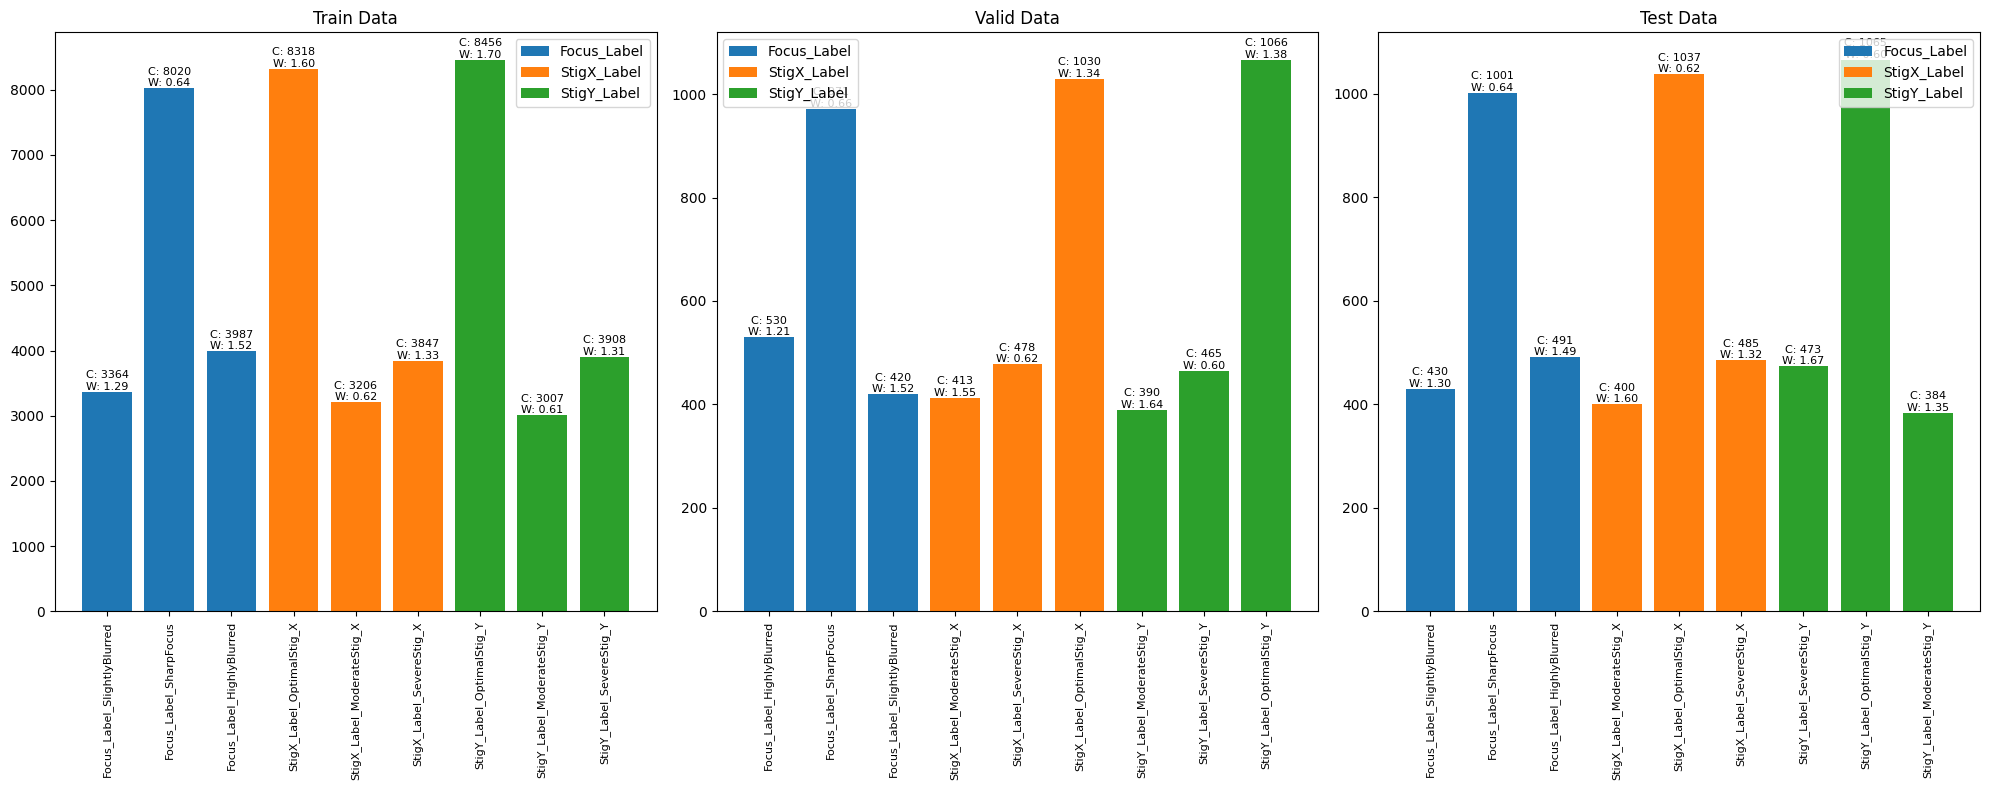

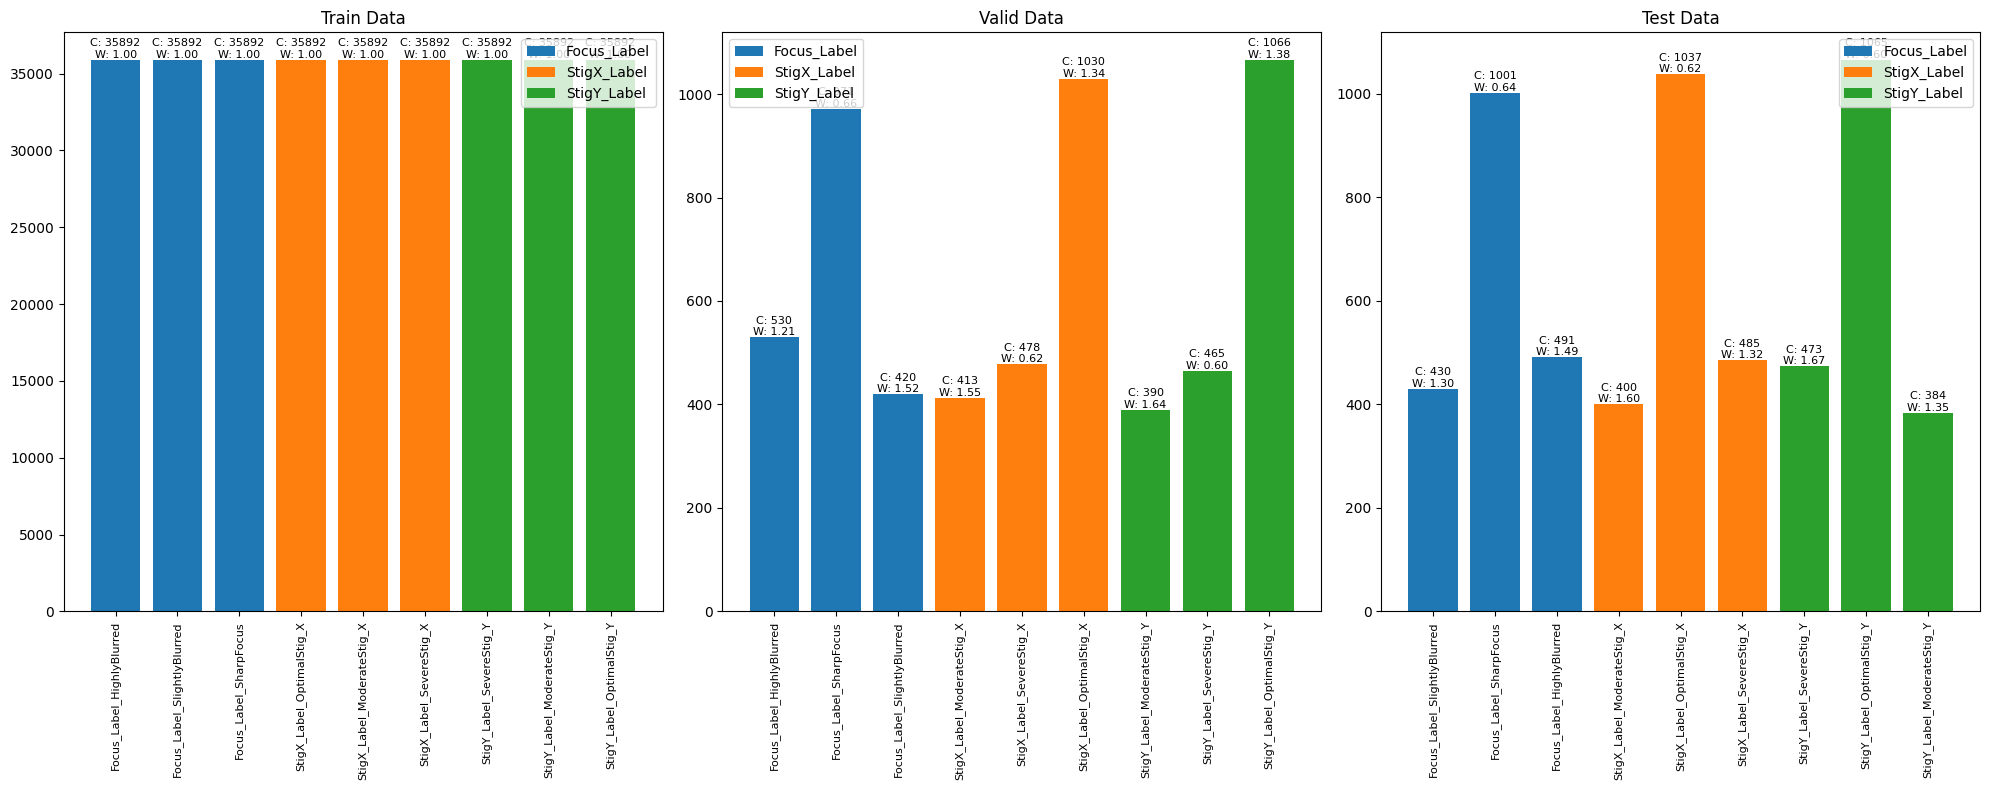

In [30]:
# Show Class Distributions

def add_annotations(ax, bars, sub_df):
    for bar, (_, row) in zip(bars, sub_df.iterrows()):
        x = bar.get_x() + bar.get_width() / 2.0
        y = bar.get_height()
        ax.annotate(f"C: {int(row['Count'])}\nW: {row['Weight']:.2f}", 
                    (x, y), 
                    ha='center', 
                    va='bottom', 
                    fontsize=8)

def plot_single_split(ax, df, split):
    filtered_df = df.loc[split]
    x_ticks = []
    x_tick_locs = []
    
    current_x = 0  # Keep track of the current x-location for ticks
    
    labels = filtered_df.index.get_level_values('label').unique()
    for label in labels:
        sub_df = filtered_df.loc[label]
        bars = ax.bar(sub_df.index, sub_df['Count'], label=f"{label}")
        add_annotations(ax, bars, sub_df)
        
        x_ticks.extend([f"{label}_{cls}" for cls in sub_df.index])
        x_tick_locs.extend([current_x + i for i in range(len(sub_df.index))])
        
        current_x += len(sub_df.index)  # Update the x-location for the next set of bars
    
    ax.legend()
    ax.set_xticks(x_tick_locs)  # Set tick locations
    ax.set_xticklabels(x_ticks, rotation=90, fontsize=8)  # Now set tick labels
    ax.set_title(f"{split.capitalize()} Data")


def plot_dataset_info(df):
    splits = ['train', 'valid', 'test']
    
    fig, axs = plt.subplots(1, len(splits), figsize=(20, 8))
    
    for i, split in enumerate(splits):
        plot_single_split(axs[i], df, split)
        
    plt.tight_layout()
    plt.show()


# Example usage
plot_dataset_info(df_class_weights)
plot_dataset_info(rdf_class_weights)

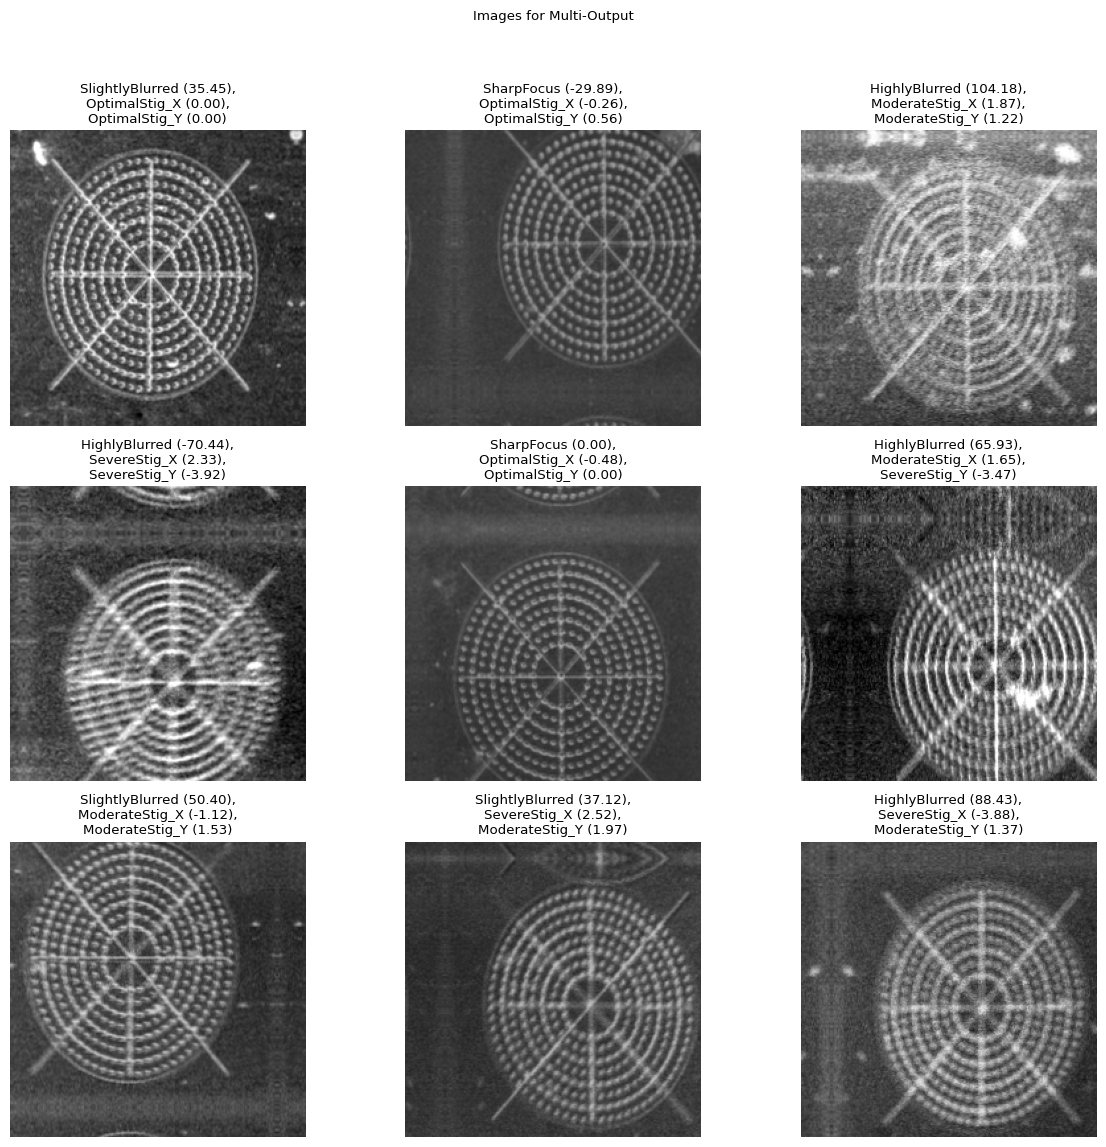

In [31]:
import textwrap
import matplotlib.pyplot as plt

def plot_images_from_dataset(label_encoders, config, datasets):
    """
    Plots images, labels, and offsets (if available) from the provided datasets.
    
    Args:
        label_encoders (dict): Dictionary of label encoders for each label key.
        config (dict): Configuration dictionary containing problem type and other parameters.
        datasets (dict): Dictionary of datasets, containing training data for each label key.
        
    Returns:
        None
    """
    label_keys = ['Focus_Label', 'StigX_Label', 'StigY_Label']
    problem_type = config['Experiment']['PROBLEM_TYPE']

    plt.rcParams.update({'font.size': 8})  # Reduce font size
    fig, axes = plt.subplots(3, 3, figsize=(12, 12))  # Enlarge figure size

    if problem_type in ['Multi-Class', 'Binary']:
        for label_key in label_keys:
            label_encoder = label_encoders.get(label_key, None)
            fig.suptitle(f"Images for {label_key}")

            # Take one batch from the training dataset
            for data in datasets['train'][label_key].take(1):
                images, labels = data[:2]
                offsets = data[2] if len(data) > 2 else None  # Include offsets if they exist

                # Loop over the batch to plot images, labels, and offsets
                for i in range(min(len(images), 9)):  # Show up to 9 images
                    ax = axes[i // 3, i % 3]
                    ax.imshow(images[i].numpy())

                    label_value = labels[i].numpy()
                    offset_value = offsets[i].numpy() if offsets is not None else "N/A"

                    # Use label encoder to get original label name if available
                    if label_encoder:
                        label_name = label_encoder.inverse_transform([label_value])[0]
                    else:
                        label_name = label_value

                    ax.set_title(f"{label_name} (Offset: {offset_value})")
                    ax.axis("off")

            plt.tight_layout(rect=[0, 0.03, 1, 0.95])
            plt.show()

    elif problem_type == 'Multi-Output':
        fig.suptitle("Images for Multi-Output")

        # Take one batch from the training dataset
        for data in datasets['train']['Multi_Output'].take(1):
            images, labels = data[:2]
            offsets = data[2] if len(data) > 2 else None  # Include offsets if they exist

            # Loop over the batch to plot images, labels, and offsets
            for i in range(min(len(images), 9)):  # Show up to 9 images
                ax = axes[i // 3, i % 3]
                ax.imshow(images[i].numpy())

                label_values = labels[i].numpy()
                offset_values = offsets[i].numpy() if offsets is not None else ["N/A"] * len(label_keys)
                # Round offset values to 2 decimal places
                offset_values = [f"{offset:.2f}" for offset in offset_values]

                label_names = []
                for label_value, label_key in zip(label_values, label_keys):
                    label_encoder = label_encoders.get(label_key, None)
                    if label_encoder:
                        label_names.append(label_encoder.inverse_transform([label_value])[0])
                    else:
                        label_names.append(str(label_value))

                title_text = ", ".join(f"{name} ({offset})" for name, offset in zip(label_names, offset_values))
                ax.set_title("\n".join(textwrap.wrap(title_text, 30)))  # Wrap text to limit the width
                ax.axis("off")

            plt.tight_layout(rect=[0, 0.03, 1, 0.95])
            plt.show()
    else:
        print("Unknown problem type specified in config. Please check.")

plot_images_from_dataset(label_encoders, config, datasets)


## Model Creation

### Define the Models

In [32]:
def add_multi_output_heads(base_layer, num_classes: int, output_names: List[str]):
    outputs = []
    for i in range(num_classes):
        x = layers.Dense(128, activation="relu")(base_layer)
        x = layers.Dropout(0.5)(x)
        x = layers.Dense(3, activation="softmax", name=output_names[i])(x)  # Naming each output layer
        outputs.append(x)
    return outputs


def create_transfer_model(base_model, input_shape: tuple, num_classes: int, hidden_units: list, dropout_rate: float, regularizer_rate: float, output_names: List[str] = None) -> keras.Model:
    """Creates a transfer learning model based on the provided base model."""
    base_model.trainable = False
    model = keras.Sequential([
        base_model,
        layers.GlobalAveragePooling2D()
    ])
    for units in hidden_units:
        model.add(layers.Dense(units, kernel_regularizer=keras.regularizers.l2(regularizer_rate), bias_regularizer=keras.regularizers.l2(regularizer_rate)))
        model.add(layers.LeakyReLU())
        model.add(layers.Dropout(dropout_rate))
    
    activations, units_list = determine_activation_and_units(num_classes)
    if len(activations) == 1:
        # Single output
        model.add(layers.Dense(units_list[0], activation=activations[0]))
        return model
    else:
        # Multiple outputs
        # outputs = add_multi_output_heads(model.layers[-1].output, num_classes)
        output_names=list(config['Labels']['MAPPINGS'].keys())
        outputs = add_multi_output_heads(model.layers[-1].output, num_classes, output_names)
        return keras.Model(inputs=model.input, outputs=outputs)


def create_mobilenetv2_transfer_model(input_shape: tuple, num_classes: int) -> keras.Model:
    """Creates a MobileNetV2 based transfer learning model."""
    base_model = tf.keras.applications.MobileNetV2(input_shape=input_shape, include_top=False, weights='imagenet')
    # return create_transfer_model(base_model, input_shape, num_classes, [128, 64], 0.5, 0.001)
    return create_transfer_model(base_model, input_shape, num_classes, [128, 64], 0.5, 0.001, output_names=config['Labels']['MAPPINGS'].keys())


def create_inceptionv3_transfer_model(input_shape: tuple, num_classes: int) -> keras.Model:
    """Creates an InceptionV3 based transfer learning model."""
    base_model = tf.keras.applications.InceptionV3(input_shape=input_shape, include_top=False, weights='imagenet')
    # return create_transfer_model(base_model, input_shape, num_classes, [128, 64], 0.5, 0.001)
    return create_transfer_model(base_model, input_shape, num_classes, [128, 64], 0.5, 0.001, output_names=config['Labels']['MAPPINGS'].keys())


def create_resnet50_transfer_model(input_shape: tuple, num_classes: int) -> keras.Model:
    """Creates a ResNet50 based transfer learning model."""
    base_model = tf.keras.applications.ResNet50(input_shape=input_shape, include_top=False, weights='imagenet')
    # return create_transfer_model(base_model, input_shape, num_classes, [256, 128], 0.5, 0.001)
    return create_transfer_model(base_model, input_shape, num_classes, [128, 64], 0.5, 0.001, output_names=config['Labels']['MAPPINGS'].keys())


# Define the function to create a basic CNN model
def create_basic_cnn_model(input_shape, num_classes):
    conv2d_filter_size = (3, 3)
    conv2d_activation = 'relu'
    dense_activation = 'relu'
    num_conv_blocks = 3

    inputs = keras.Input(shape=input_shape)

    x = inputs

    for _ in range(num_conv_blocks):
        x = layers.Conv2D(32 * (2**_), conv2d_filter_size, activation=conv2d_activation, padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = layers.MaxPooling2D((2, 2))(x)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(128, activation=dense_activation)(x)

    activations, units_list = determine_activation_and_units(num_classes)
    if len(activations) == 1:
        # Single output
        x = layers.Dense(units_list[0], activation=activations[0])(x)
        return keras.Model(inputs=inputs, outputs=x)
    else:
        # Multiple outputs
        outputs = add_multi_output_heads(x, num_classes, output_names=list(config['Labels']['MAPPINGS'].keys()))
        return keras.Model(inputs=inputs, outputs=outputs)




# Define the function to create a small version of the Xception network
def create_small_xception_model(input_shape, num_classes):
    # Input layer
    inputs = keras.Input(shape=input_shape)

    # Entry block: Initial Convolution and BatchNormalization
    x = layers.Rescaling(1.0 / 255)(inputs)
    x = layers.Conv2D(128, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    previous_block_activation = x  # Set aside residual for later use

    # Middle flow: Stacking Separable Convolution blocks
    for size in [256, 512, 728]:
        # ReLU activation
        x = layers.Activation("relu")(x)
        # Separable Convolution
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        # ReLU activation
        x = layers.Activation("relu")(x)
        # Separable Convolution
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        # Max Pooling
        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual from previous block and add it to the current block
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(previous_block_activation)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # Exit flow: Final Separable Convolution, BatchNormalization, and Global Average Pooling
    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.GlobalAveragePooling2D()(x)

    activations, units_list = determine_activation_and_units(num_classes)
    if len(activations) == 1:
        # Single output
        x = layers.Dense(units_list[0], activation=activations[0])(x)
        return keras.Model(inputs=inputs, outputs=x)
    else:
        # Multiple outputs
        outputs = add_multi_output_heads(x, num_classes, output_names=list(config['Labels']['MAPPINGS'].keys()))
        return keras.Model(inputs=inputs, outputs=outputs)


# Model Selection function to select which model to use
def select_model(model_name: str, input_shape: tuple, num_classes: int) -> keras.Model:
    """Selects a model to use based on the given model name."""
    model_map = {
        "mobilenetv2": create_mobilenetv2_transfer_model,
        "inceptionv3": create_inceptionv3_transfer_model,
        "resnet50": create_resnet50_transfer_model,
        "small_xception": create_small_xception_model,
        "basic_cnn": create_basic_cnn_model
    }
    if model_name not in model_map:
        raise ValueError("Invalid model name")

    return model_map[model_name](input_shape, num_classes)

def determine_activation_and_units(num_classes: int) -> tuple:
    """Determine the activation function and units based on the number of classes and problem type from config."""
    problem_type = config.get('Experiment').get('PROBLEM_TYPE')
    if problem_type == 'Multi-Label':
        return ["sigmoid"] * num_classes, [1] * num_classes
    elif problem_type == 'Binary' or num_classes == 2:
        return ["sigmoid"], [1]
    elif problem_type == 'Multi-Class':
        return ["softmax"], [num_classes]
    elif problem_type == 'Multi-Output':
        return ["softmax"] * num_classes, [3] * num_classes  # Assuming each output has 3 classes
    else:
        raise ValueError(f"Invalid problem_type: {problem_type}")

    

### Compile the Models

In [33]:
# for metric in compiled_models['mobilenetv2']['model'].metrics:
#     print(f"Metric Name: {metric.name}, Config: {metric.get_config()}")


NameError: name 'compiled_models' is not defined

In [ ]:
from tensorflow import keras
from tensorflow.keras import callbacks, optimizers
import os
from datetime import datetime

# Constants & Configurations
# Update for Multi-Output case
LOSS_CONFIG = {
    'Binary': 'binary_crossentropy',
    'Multi-Class': 'categorical_crossentropy',
    'Multi-Output': ['categorical_crossentropy'] * len(config['Labels']['MAPPINGS']),
    'Multi-Label': 'binary_crossentropy'
}

RECOMMENDED_METRICS = {
    'Binary': ['accuracy', 'binary_crossentropy', 'mean_squared_error'],
    'Multi-Class': ['categorical_accuracy', 'categorical_crossentropy', 'mean_squared_error'],
    'Multi-Output': ['categorical_accuracy'] * len(config['Labels']['MAPPINGS']) + 
                    ['categorical_crossentropy'] * len(config['Labels']['MAPPINGS']) + 
                    ['mean_squared_error'] * len(config['Labels']['MAPPINGS']),
    'Multi-Label': ['binary_accuracy', 'binary_crossentropy', 'mean_squared_error']
}



# Helper Functions
def get_accuracy_metric(problem_type):
    """Determine the accuracy metric based on the problem type."""
    metric_map = {
        'Binary': "accuracy",
        'Multi-Label': "binary_accuracy",
    }
    return metric_map.get(problem_type, "categorical_accuracy")


def create_directory(path):
    """Create a directory if it doesn't exist."""
    os.makedirs(path, exist_ok=True)


# Callback Setup Functions
def setup_common_callbacks():
    """Set up common callbacks."""
    return [
        callbacks.EarlyStopping(
            patience=config['Model']['EARLY_STOPPING_PATIENCE'], 
            restore_best_weights=True
        ),
        callbacks.ReduceLROnPlateau(
            patience=config['Model']['REDUCE_LR_PATIENCE'], 
            min_lr=config['Model']['MIN_LR']
        )
    ]


def setup_specific_callbacks(model_name, model_dir, problem_type):
    """Set up model-specific callbacks."""
    datetime_str = datetime.now().strftime("%Y%m%d-%I%M%S%p")
    acc_metric = get_accuracy_metric(problem_type)
    
    checkpoint_path = os.path.join(
        model_dir, 
        f"saved_model_{datetime_str}_epoch_{{epoch}}_val_loss_{{val_loss:.2f}}_{acc_metric}_{{{{val_{acc_metric}:.2f}}}}.h5"
    )
    return [
        callbacks.ModelCheckpoint(checkpoint_path, save_best_only=True),
        callbacks.TensorBoard(log_dir=os.path.join(model_dir, "logs", datetime_str))
    ]


# Model Compilation Functions
def compile_model(model_name, input_shape, num_classes, problem_type):
    """Compile and return a model."""
    model = select_model(model_name, input_shape, num_classes)
    
    # Choose the correct loss and metrics
    metrics_to_use = RECOMMENDED_METRICS.get(problem_type, ['accuracy'])
    metrics_to_use = list(set(metrics_to_use))

    loss_to_use = LOSS_CONFIG.get(problem_type, 'categorical_crossentropy')
    
    model.compile(
        optimizer=keras.optimizers.Adam(config['Model']['LEARNING_RATE']), 
        loss=loss_to_use, 
        metrics=metrics_to_use
    )
    
    model.summary()
    return model




def compile_and_initialize_models():
    """Main function to compile and initialize models."""
    input_shape = (config['Model']['IMG_SIZE'], config['Model']['IMG_SIZE'], 3)
    num_classes = 3
    problem_type = config['Experiment']['PROBLEM_TYPE']

    experiment_name = f"{config['Experiment']['NAME']}"
    base_dir = f"./{experiment_name}"
    create_directory(base_dir)

    common_callbacks = setup_common_callbacks()
    label_names = config['Labels']['MAPPINGS'].keys() if problem_type in ['Multi-Class', 'Multi-Output'] else ['']


    compiled_models = {}
    for label_name in label_names:
        label_dir = os.path.join(base_dir, label_name)
        create_directory(label_dir)

        for model_name in ['mobilenetv2', 'inceptionv3', 'resnet50', 'small_xception', 'basic_cnn']:
            model_dir = os.path.join(label_dir, model_name)
            create_directory(model_dir)
            
            specific_callbacks = setup_specific_callbacks(model_name, model_dir, problem_type)
            all_callbacks = common_callbacks + specific_callbacks
            
            model = compile_model(model_name, input_shape, num_classes, problem_type)
            compiled_models[model_name] = {'model': model, 'callbacks': all_callbacks}
    
    return compiled_models

# Execution
compiled_models = compile_and_initialize_models()
print("Models compiled and initialized successfully.")


Model: "model_67"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 mobilenetv2_1.00_224_input (In  [(None, 224, 224, 3  0          []                               
 putLayer)                      )]                                                                
                                                                                                  
 mobilenetv2_1.00_224 (Function  (None, 7, 7, 1280)  2257984     ['mobilenetv2_1.00_224_input[0][0
 al)                                                             ]']                              
                                                                                                  
 global_average_pooling2d_80 (G  (None, 1280)        0           ['mobilenetv2_1.00_224[0][0]']   
 lobalAveragePooling2D)                                                                    

In [ ]:
# Check the Model's Outputs Directly:

for output_layer in compiled_models['mobilenetv2']['model'].output:
    print(output_layer.name, output_layer.shape)
    


Focus_Label/Softmax:0 (None, 3)
StigX_Label/Softmax:0 (None, 3)
StigY_Label/Softmax:0 (None, 3)


## Train the Models

### Preparing Training Inputs

In [ ]:
# Prepare class weights for training

def prepare_class_weights_for_multi_output(info: pd.DataFrame) -> Union[Dict[str, Dict[int, float]], None]:
    """
    Prepare class weights for multi-output problems for Keras and TensorFlow.
    
    Parameters:
    - info: DataFrame containing the class weights information
    - config: Configuration dictionary.
    
    Returns:
    - Dictionary mapping output layer names to their respective class weight dictionaries or None
    """
    if not config.get('USE_CLASS_WEIGHTS', True):
        print("Configuration says not to use class weights. Returning None.")
        return None

    class_weights = {}
    for label in info.index.get_level_values('label').unique():
        class_weights[label] = {}
        sub_df = info.loc[(slice(None), label), :]
        for idx, row in sub_df.iterrows():
            class_idx = label_encoders[label].transform([idx[2]])[0]  # Transforming class name to class index
            class_weights[label][class_idx] = row['Weight']
    return class_weights

# Additions to the config
config['USE_CLASS_WEIGHTS'] = True  # Decide whether to use class weights or not

prepared_class_weights = prepare_class_weights_for_multi_output(df_class_weights)
print(prepared_class_weights)

{'Focus_Label': {1: 1.481159420289855, 0: 0.5257201646090535, 2: 2.365740740740741}, 'StigX_Label': {0: 0.4554367201426025, 1: 1.9356060606060606, 2: 3.4761904761904763}, 'StigY_Label': {1: 1.9578544061302683, 0: 3.3398692810457518, 2: 0.45665773011617516}}


In [ ]:
# Preparing datasets for training

def inspect_dataset_content(dataset, name, num_batches=3):
    """
    Inspect the content of the dataset to determine the nature of the tensors.
    
    Parameters:
    - dataset: A TensorFlow dataset.
    - name: The name of the dataset ('Train', 'Validation', 'Test')
    - num_batches: Number of batches to inspect from the dataset.
    """
    print(f"Inspecting first few records of {name} dataset...")
    
    for i, record in enumerate(dataset.take(num_batches)):
        summary = {k: (v.shape, v.dtype) for k, v in enumerate(record)}
        print(f"{name} record {i + 1}: {summary}")
        
    print(f"Inspecting unique values in {name} dataset...")
    
    for i, batch in enumerate(dataset.take(num_batches)):
        print(f"Batch {i + 1} content:")
        
        for j, tensor in enumerate(batch):
            # Check unique values in each tensor
            unique_values = tf.unique(tf.reshape(tensor, [-1])).y.numpy()
            print(f"Unique values in tensor {j}: {unique_values}")
        
        print("------")

# Function to select appropriate tensors from the dataset
def select_tensors(*tensors):
    return tensors[0], tensors[1]  # Return only the image and label tensors
    # return tensors[0], tensors[1], tensors[2]  # Assuming tensors[2] is the offset tensor


def prepare_datasets_for_training(raw_datasets):
    """
    Prepare and inspect datasets for training.

    Parameters:
    - raw_datasets: A dictionary containing raw TensorFlow datasets.

    Returns:
    - prepared_datasets: A dictionary containing prepared TensorFlow datasets for training, validation, and testing.
    """
    # Check if the dataset dictionary is None
    if raw_datasets is None:
        print("Datasets dictionary is None. Exiting.")
        return None

    # Separate datasets into train, valid, and test
    train_dataset = raw_datasets.get('train', {}).get('Multi_Output')
    valid_dataset = raw_datasets.get('valid', {}).get('Multi_Output')
    test_dataset = raw_datasets.get('test', {}).get('Multi_Output')
    
    # Select appropriate tensors for training and validation
    train_dataset = train_dataset.map(select_tensors)
    valid_dataset = valid_dataset.map(select_tensors)
    test_dataset = test_dataset.map(select_tensors)

    if train_dataset is None or valid_dataset is None or test_dataset is None:
        print("One or more datasets are None. Exiting.")
        return None

    # Inspect the datasets
    # for name, dataset in [('Train', train_dataset), ('Validation', valid_dataset), ('Test', test_dataset)]:
    #     inspect_dataset_content(dataset, name)

    return train_dataset, valid_dataset, test_dataset

# Uncomment this line to run the function with your datasets
train_dataset, valid_dataset, test_dataset = prepare_datasets_for_training(datasets)
# train_dataset, valid_dataset, test_dataset = prepare_datasets_for_training(resampled_datasets)

### Training the Models

In [ ]:
# def compute_sample_weights(dataset, class_weights):
#     """
#     Compute sample weights for a given dataset based on the provided class weights.

#     Parameters:
#     - dataset: A TensorFlow dataset.
#     - class_weights: A dictionary containing class weights for each output.

#     Returns:
#     - sample_weights_list: A list containing sample weights for each sample in the dataset.
#     """
#     sample_weights_list = []

#     # Iterate over the dataset to compute sample weights for each sample
#     for images, labels in dataset:
#         sample_weights = []

#         # For multi-output, labels will be a tuple of label arrays
#         for idx, label_arr in enumerate(labels):
#             # Extract the class weights for the current output
#             weights = class_weights[idx]

#             # Compute the sample weight for each sample based on its label
#             sample_weight = [weights[label] for label in label_arr.numpy()]
#             sample_weights.append(sample_weight)

#         # Average the sample weights for multi-output to get a single weight for each sample
#         avg_sample_weights = np.mean(sample_weights, axis=0)
#         sample_weights_list.extend(avg_sample_weights)

#     return sample_weights_list

# # Convert the class weights from dictionary format to a list format
# class_weights_list = [prepared_class_weights[key] for key in prepared_class_weights]

# # Compute sample weights for the train_dataset
# train_sample_weights = compute_sample_weights(train_dataset, class_weights_list)
# def add_sample_weights_to_dataset(dataset, sample_weights):
#     """
#     Add sample weights to a dataset.

#     Parameters:
#     - dataset: A TensorFlow dataset without sample weights.
#     - sample_weights: A list of sample weights.

#     Returns:
#     - A TensorFlow dataset with sample weights added.
#     """
#     # Convert the dataset to a list of (features, labels) pairs
#     data_list = list(dataset)
#     features = [item[0] for item in data_list]
#     labels = [item[1] for item in data_list]

#     # Combine features, labels, and sample weights into a tuple
#     data_with_weights = (features, labels, sample_weights)

#     # Create a new dataset from the tuple
#     dataset_with_weights = tf.data.Dataset.from_tensor_slices(data_with_weights)

#     return dataset_with_weights

# # Adding sample weights to the train_dataset
# train_dataset_with_weights = add_sample_weights_to_dataset(train_dataset, train_sample_weights)

# # Checking the first few records of the updated train_dataset
# list(train_dataset_with_weights.take(3))



In [ ]:
from tensorflow.keras.callbacks import Callback
import pandas as pd
import os

class ExcelMetricsSaver(Callback):
    def __init__(self, writer, sheet_name):
        super().__init__()
        self.writer = writer
        self.sheet_name = sheet_name

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        logs['epoch'] = epoch + 1  # Add epoch number to logs
        epoch_df = pd.DataFrame([logs])
        if epoch == 0:
            epoch_df.to_excel(self.writer, sheet_name=self.sheet_name, index=False)
        else:
            book = self.writer.book
            writer_sheets = self.writer.sheets
            worksheet = writer_sheets[self.sheet_name]
            start_row = worksheet.max_row
            epoch_df.to_excel(self.writer, sheet_name=self.sheet_name, startrow=start_row, header=False, index=False)

In [ ]:
def compute_sample_weights_for_batch(labels_batch, class_weights):
    """
    Compute sample weights for a given batch of labels.

    Args:
    - labels_batch (dict): Dictionary containing batched labels for each output.
                           Keys are output names, and values are numpy arrays of labels.
    - class_weights (dict): Dictionary containing class weights for each output.
                            Keys are output names, and values are dictionaries mapping class labels to weights.

    Returns:
    - sample_weights (dict): Dictionary containing computed sample weights for each output.
                             Keys are output names, and values are numpy arrays of sample weights.
    """
    sample_weights = {}
    for output_name, labels in labels_batch.items():
        weights_for_output = class_weights[output_name]
        sample_weights_for_output = np.array([weights_for_output[label] for label in labels])
        sample_weights[output_name] = sample_weights_for_output
    return sample_weights

# Test the function with a sample batch (for demonstration purposes)
sample_labels_batch = {
    'Focus_Label': np.array([0, 1, 2, 0]),
    'StigX_Label': np.array([1, 1, 0, 2]),
    'StigY_Label': np.array([2, 0, 1, 1])
}

sample_weights_batch = compute_sample_weights_for_batch(sample_labels_batch, prepared_class_weights)
sample_weights_batch


{'Focus_Label': array([0.52572016, 1.48115942, 2.36574074, 0.52572016]),
 'StigX_Label': array([1.93560606, 1.93560606, 0.45543672, 3.47619048]),
 'StigY_Label': array([0.45665773, 3.33986928, 1.95785441, 1.95785441])}

In [ ]:
def train_and_save_metrics(train_dataset, valid_dataset, test_dataset, compiled_models, prepared_class_weights):
    try:
        if train_dataset is None or valid_dataset is None or test_dataset is None:
            print("One or more datasets are None. Exiting.")
            return

        excel_filename = f"{config['Experiment']['NAME']}.xlsx"
        excel_path = os.path.join("./", excel_filename)

        with pd.ExcelWriter(excel_path, engine='openpyxl') as writer:
            pd.DataFrame().to_excel(writer, sheet_name="InitializationSheet")

            for model_name, model_info in compiled_models.items():
                model = model_info.get('model')
                callbacks = model_info.get('callbacks')

                if model is None or callbacks is None:
                    print(f"Model or callbacks for {model_name} are None. Skipping.")
                    continue

                print(f"Training {model_name} for multi-output...")
                
                excel_saver = ExcelMetricsSaver(writer, sheet_name=f"{model_name}")
                callbacks.append(excel_saver)

                # Adjusting class weights for multi-output to match expected format
                multi_output_class_weights = {}
                for idx, output_name in enumerate(model.output_names):
                    simple_name = output_name.split('/')[0]  # Extracting 'Focus_Label' from 'Focus_Label/Softmax:0' for example
                    multi_output_class_weights[idx] = prepared_class_weights[simple_name]

                history = model.fit(
                    train_dataset,
                    validation_data=valid_dataset,
                    epochs=config['Model']['EPOCHS'],
                    # class_weight=multi_output_class_weights,  # Adjusted for multi-output
                    callbacks=callbacks
                )

                print(f"\nTraining for {model_name} completed.")

        print(f"\nSaved all metrics to {excel_path}")

    except Exception as e:
        print(f"\nAn error occurred: {e}")

train_and_save_metrics(train_dataset, valid_dataset, test_dataset, compiled_models, prepared_class_weights)


Training mobilenetv2 for multi-output...
Epoch 1/100
 79/511 [===>..........................] - ETA: 2:22 - loss: 9.8341 - Focus_Label_loss: 3.2041 - StigX_Label_loss: 3.1723 - StigY_Label_loss: 3.1534 - Focus_Label_mean_squared_error: 0.6513 - Focus_Label_categorical_crossentropy: 3.2041 - Focus_Label_categorical_accuracy: 0.4051 - StigX_Label_mean_squared_error: 0.6486 - StigX_Label_categorical_crossentropy: 3.1723 - StigX_Label_categorical_accuracy: 0.3631 - StigY_Label_mean_squared_error: 0.6467 - StigY_Label_categorical_crossentropy: 3.1534 - StigY_Label_categorical_accuracy: 0.4043

## View Model Performance

KeyError: 'categorical_accuracy'

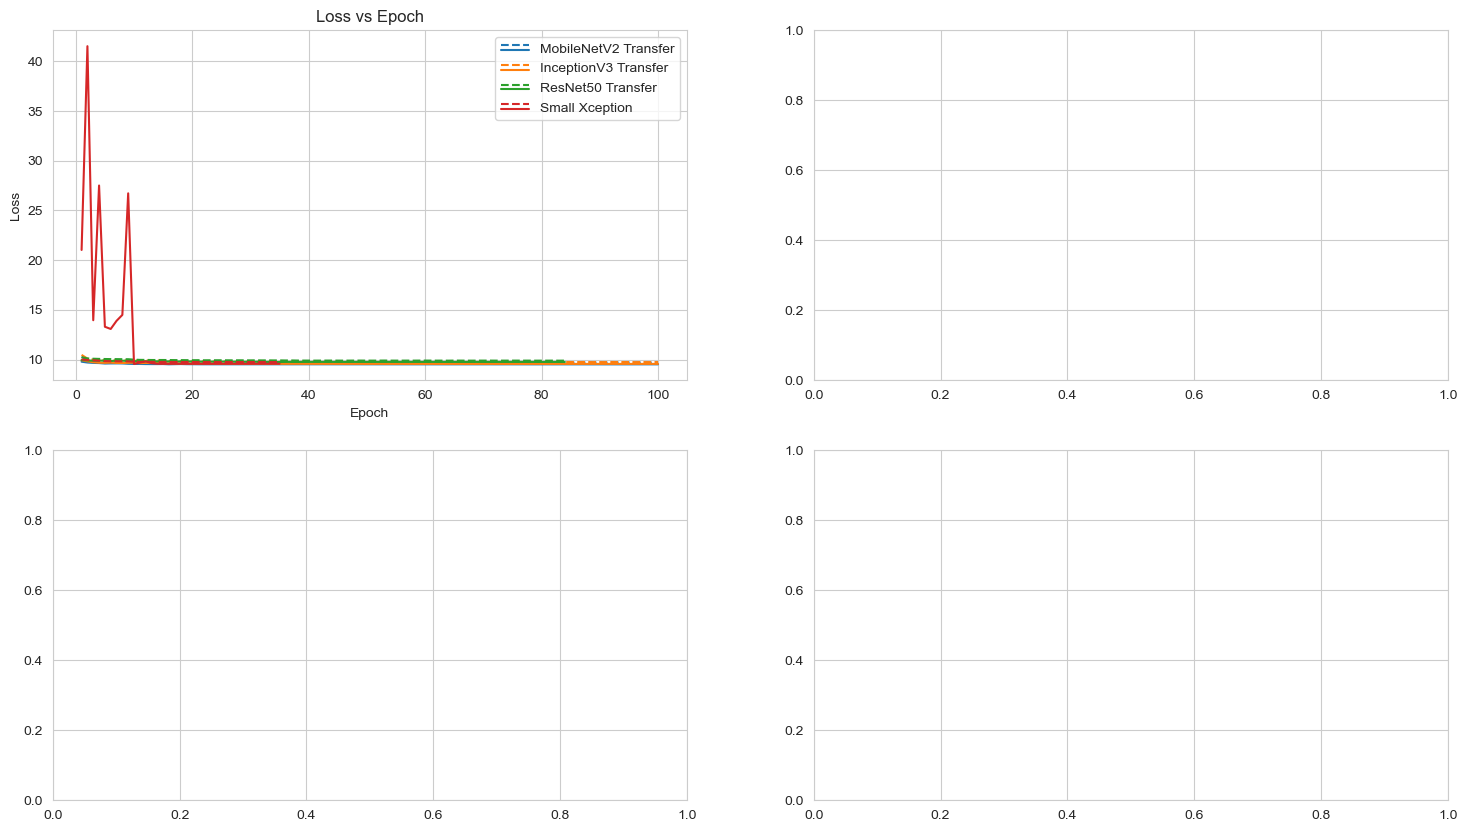

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from matplotlib.legend_handler import HandlerTuple

class HandlerTupleVertical(HandlerTuple):
    def create_artists(self, legend, orig_handle, xdescent, ydescent, width, height, fontsize, trans):
        numlines = len(orig_handle)
        handler_map = legend.get_legend_handler_map()
        height_y = (height / numlines)
        leglines = []
        for i, handle in enumerate(orig_handle):
            handler = legend.get_legend_handler(handler_map, handle)
            legline = handler.create_artists(legend, handle, xdescent, (2*i + 1)*height_y, width, 2*height, fontsize, trans)
            leglines.extend(legline)
        return leglines

def get_dataframes_from_excel(xls):
    """Load DataFrames from the Excel file."""
    model_names = xls.sheet_names
    return {model_name: pd.read_excel(xls, model_name) for model_name in model_names}

def plot_metrics(ax, dfs, metric, readable_metric, color_dict):
    """Plot metrics for all models on a single graph."""
    for model_name, cleaned_name in zip(dfs.keys(), color_dict.keys()):
        epochs = dfs[model_name]['epoch']
        ax.plot(epochs, dfs[model_name][f'{metric}'], '--', color=color_dict[cleaned_name], label=f"{cleaned_name}") #Training
        ax.plot(epochs, dfs[model_name][f'val_{metric}'], '-', color=color_dict[cleaned_name], label=f"{cleaned_name}") #Validation
    ax.set_title(f"{readable_metric} vs Epoch")
    ax.set_xlabel('Epoch')
    ax.set_ylabel(readable_metric)
    
model_name_mapping = {
    "mobilenetv2": "MobileNetV2 Transfer",
    "inceptionv3": "InceptionV3 Transfer",
    "resnet50": "ResNet50 Transfer",
    "small_xception": "Small Xception",
    "basic_cnn": "Basic CNN"
}
def plot_metrics_from_excel(excel_path):
    # Load the Excel file and get DataFrames
    xls = pd.ExcelFile(excel_path)
    model_names = xls.sheet_names
    dfs = get_dataframes_from_excel(xls)
    readable_model_names = [model_name_mapping.get(name, name) for name in model_names]
    
    # Metrics mapping and Seaborn style
    metric_mapping = {
        'loss': 'Loss',
        'categorical_accuracy': 'Categorical Accuracy',
        'categorical_crossentropy': 'Categorical Crossentropy',
        'mean_squared_error': 'Mean Squared Error'
    }
    sns.set_style("whitegrid")
    palette = sns.color_palette("tab10", len(model_names))
    color_dict = {readable_name: palette[i] for i, readable_name in enumerate(readable_model_names)}
    
    # Plotting
    fig, axes = plt.subplots(2, 2, figsize=(18, 10))
    axes_flat = axes.ravel()
    for i, (metric, readable_metric) in enumerate(metric_mapping.items()):
        plot_metrics(axes_flat[i], dfs, metric, readable_metric, color_dict)
        # Add legend to each subplot
        handles, labels = axes_flat[i].get_legend_handles_labels()
        new_handles = [(handles[j], handles[j + 1]) for j in range(0, len(handles), 2)]
        axes_flat[i].legend(new_handles, labels[::2], handler_map={tuple: HandlerTupleVertical()})
    
    # Add main title
    experiment_name = os.path.basename(excel_path).replace(".xlsx", "")
    fig.suptitle(f"Metrics for {experiment_name}", fontsize=20, y=1.08)
    
    # Add informational note below the subplots
    note_text = r"$\bf{Models}$" + "\nTraining (Dashed) | Validation (Solid)"
    fig.text(0.5, -0.02, note_text, ha='center', fontsize=10, transform=fig.transFigure)
    
    fig.tight_layout()
    
    # Save and display
    base_dir = os.path.dirname(excel_path)
    output_dir = os.path.join(base_dir, f"Plots/{experiment_name}")
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    save_path = os.path.join(output_dir, "Metrics_vs_Epoch.png")
    plt.savefig(save_path, bbox_inches='tight')
    plt.show()

    return save_path

# Mocking the actual plot as the excel_path is not available
excel_path = 'DOE_v2_SIM.xlsx'
improved_save_path = plot_metrics_from_excel(excel_path)
improved_save_path


In [4]:
def extract_key_metrics_updated(excel_path):
    """Extract key metrics from the provided Excel file without using determine_engine."""
    # Load the Excel file and get DataFrames
    xls = pd.ExcelFile(excel_path, engine="openpyxl")
    dfs = get_dataframes_from_excel(xls)

    return {
        model_name: {
            "Min Validation Loss": df["val_loss"].min(),
            "Epoch at Min Validation Loss": df["epoch"].iloc[
                df["val_loss"].idxmin()
            ],
            "Max Validation Categorical Accuracy": df[
                "val_categorical_accuracy"
            ].max(),
            "Epoch at Max Validation Categorical Accuracy": df["epoch"].iloc[
                df["val_categorical_accuracy"].idxmax()
            ],
            "Min Validation Categorical Crossentropy": df[
                "val_categorical_crossentropy"
            ].min(),
            "Epoch at Min Validation Categorical Crossentropy": df[
                "epoch"
            ].iloc[df["val_categorical_crossentropy"].idxmin()],
            "Min Validation Mean Squared Error": df[
                "val_mean_squared_error"
            ].min(),
            "Epoch at Min Validation Mean Squared Error": df["epoch"].iloc[
                df["val_mean_squared_error"].idxmin()
            ],
        }
        for model_name, df in dfs.items()
    }


def visualize_metric_comparison_with_mapping_annotated(file_paths, name_mapping, metric_key, metric_title, epoch_key):
    """Visualize a specific metric across experiments using a name mapping and annotate bars with epoch numbers."""
    metric_data = {}
    epoch_data = {}
    
    # Extract specific metric and epoch data
    for excel_path in file_paths:
        experiment_name = os.path.basename(excel_path).replace(".xlsx", "")
        metrics = extract_key_metrics_updated(excel_path)
        
        # Use the model_name_mapping to rename models
        mapped_metric_values = {name_mapping.get(model, model): data[metric_key] for model, data in metrics.items()}
        mapped_epoch_values = {name_mapping.get(model, model): data[epoch_key] for model, data in metrics.items()}
        
        metric_data[experiment_name] = mapped_metric_values
        epoch_data[experiment_name] = mapped_epoch_values
    
    # Convert to DataFrame for easy plotting
    metric_df = pd.DataFrame(metric_data).transpose()
    
    # Create the plot
    plt.figure(figsize=(15, 10))
    ax = metric_df.plot(kind="bar", ax=plt.gca(), colormap="viridis")
    plt.title(metric_title, fontsize=18)
    plt.ylabel(metric_key, fontsize=16)
    plt.xlabel("Experiment", fontsize=16)
    plt.legend(title="Models", bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12, title_fontsize=14)
    plt.xticks(rotation=45, fontsize=14)
    plt.yticks(fontsize=14)
    ax.grid(axis='y')
    
    # Annotate bars with epoch numbers
    for idx, rect in enumerate(ax.patches):
        experiment_idx = idx // len(metric_df.columns)
        model_idx = idx % len(metric_df.columns)
        experiment_name = metric_df.index[experiment_idx]
        model_name = metric_df.columns[model_idx]
        epoch_value = epoch_data[experiment_name][model_name]
        ax.text(rect.get_x() + rect.get_width() / 2, rect.get_height(), f'Ep {epoch_value}', ha='center', va='bottom', fontsize=10)
    
    plt.tight_layout()
    plt.show()


# Visualize all the key metrics with annotations
metric_visualization_keys_with_epochs = [
    ("Max Validation Categorical Accuracy", "Max Validation Categorical Accuracy Across Experiments", "Epoch at Max Validation Categorical Accuracy"),
    ("Min Validation Loss", "Min Validation Loss Across Experiments", "Epoch at Min Validation Loss"),
    ("Min Validation Categorical Crossentropy", "Min Validation Categorical Crossentropy Across Experiments", "Epoch at Min Validation Categorical Crossentropy"),
    ("Min Validation Mean Squared Error", "Min Validation Mean Squared Error Across Experiments", "Epoch at Min Validation Mean Squared Error")
]

for metric_key, metric_title, epoch_key in metric_visualization_keys_with_epochs:
    visualize_metric_comparison_with_mapping_annotated(
        ["DOE_2percent.xlsx", "DOE_v2_SIM.xlsx"],
        model_name_mapping,
        metric_key,
        metric_title,
        epoch_key
    )


KeyError: 'val_loss'

In [ ]:
import os
from tensorflow.keras.models import load_model

def get_best_model_filename(directory):
    """Identify the best model filename based on the minimum validation loss from the directory."""
    model_files = [f for f in os.listdir(directory) if f.endswith('.h5')]
    if not model_files:
        print(f"No model files found in {directory}")
        return None
    return min(model_files, key=lambda x: float(x.split('val_loss_')[1].split('_')[0]))

def load_best_model(directory):
    """Loads the best model from the specified directory."""
    best_model_file = get_best_model_filename(directory)
    if not best_model_file:
        return None
    best_model_path = os.path.join(directory, best_model_file)
    # return load_model(best_model_path)
    return load_model(best_model_path, compile=False)

def get_label_directories(experiment_directory):
    """Determine label directories or just model directories in the experiment directory."""
    first_level_dirs = [os.path.join(experiment_directory, d) for d in os.listdir(experiment_directory) 
                        if os.path.isdir(os.path.join(experiment_directory, d))]
    if any('mobilenetv2' in dir_name for dir_name in first_level_dirs):
        return [experiment_directory]
    return first_level_dirs

def load_all_best_models(experiment_directory):
    """Load the best model for each model type within the experiment directory."""
    best_models = {}
    label_dirs = get_label_directories(experiment_directory)
    for label_dir in label_dirs:
        for model_name in ['mobilenetv2', 'inceptionv3', 'resnet50', 'small_xception', 'basic_cnn']:
            model_dir = os.path.join(label_dir, model_name)
            best_model = load_best_model(model_dir)
            if best_model:
                key_name = f"{os.path.basename(label_dir)}_{model_name}"
                best_models[key_name] = best_model
    return best_models

# Example Usage
experiment_directory = "SIM_Unbalanced"
all_best_models = load_all_best_models(experiment_directory)
print(all_best_models.keys())  # This will display the keys of the loaded models.


dict_keys(['SIM_Unbalanced_mobilenetv2', 'SIM_Unbalanced_inceptionv3', 'SIM_Unbalanced_resnet50', 'SIM_Unbalanced_small_xception', 'SIM_Unbalanced_basic_cnn'])


In [ ]:
# # Import Scikit-Learn Confusion Matrix
# from sklearn.metrics import confusion_matrix

# def make_confusion_matrix(y_true, y_pred, classes=None, encoder=None, figsize=(10, 10), text_size=15, norm=False, savefig=False, output_num=None):
#     """
#     Makes a labelled confusion matrix comparing predictions and ground truth labels.

#     Args:
#     y_true: Array of truth labels.
#     y_pred: Array of predicted labels.
#     classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
#     encoder: Fitted LabelEncoder to transform integer labels back to original string labels.
#     ... (other arguments as before)

#     Returns:
#     A labelled confusion matrix plot comparing y_true and y_pred.
#     """
    
#     # Error handling for array shapes
#     if y_true.shape != y_pred.shape:
#         print(f"Error: Mismatch in shapes of y_true ({y_true.shape}) and y_pred ({y_pred.shape}). Skipping this output.")
#         return
    
#     if encoder:
#         y_true = encoder.inverse_transform(y_true)
#         y_pred = encoder.inverse_transform(y_pred)
    
#     # Create the confusion matrix
#     cm = confusion_matrix(y_true, y_pred)
#     cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]  # normalize it
#     n_classes = cm.shape[0]  # find the number of classes we're dealing with

#     # Plot the figure and make it pretty
#     fig, ax = plt.subplots(figsize=figsize)
#     cax = ax.matshow(cm, cmap=plt.cm.Blues)  # colors will represent how 'correct' a class is, darker == better
#     fig.colorbar(cax)

#     # Are there a list of classes?
#     labels = classes if classes else np.arange(cm.shape[0])
    
#     # Label the axes
#     ax.set(title="Confusion Matrix",
#            xlabel="Predicted label",
#            ylabel="True label",
#            xticks=np.arange(n_classes),
#            yticks=np.arange(n_classes),
#            xticklabels=labels,
#            yticklabels=labels)

#     # Make x-axis labels appear on bottom
#     ax.xaxis.set_label_position("bottom")
#     ax.xaxis.tick_bottom()

#     # Set the threshold for different colors
#     threshold = (cm.max() + cm.min()) / 2.

#     # Plot the text on each cell
#     for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
#         text = f"{cm[i, j]}" if not norm else f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)"
#         color = "white" if cm[i, j] > threshold else "black"
#         plt.text(j, i, text, horizontalalignment="center", color=color, size=text_size)

#     # Save the figure to the current working directory
#     if savefig and output_num is not None:
#         fig.savefig(f"confusion_matrix_output_{output_num + 1}.png")




# def make_confusion_matrix_multi_output(y_true, y_preds, classes=None, encoders=None, figsize=(10, 10), text_size=15, norm=False, savefig=False): 
#     """
#     Makes a labelled confusion matrix comparing predictions and ground truth labels for multi-output models.

#     Args:
#     y_true: 2D array of truth labels for multiple outputs.
#     y_preds: 2D array of predicted labels for multiple outputs.
#     classes: List of arrays of class labels (e.g. string form) for each output. If `None`, integer labels are used.
#     encoders: List of fitted LabelEncoders to transform integer labels back to original string labels for each output.
#     ... (other arguments as before)

#     Returns:
#     A list of labelled confusion matrix plots comparing y_true and y_preds for each output.
#     """
    
#     # Error handling for array shapes
#     if y_true.shape != y_preds.shape:
#         print(f"Error: Mismatch in shapes of y_true ({y_true.shape}) and y_preds ({y_preds.shape}). Cannot proceed.")
#         return
    
#     num_outputs = y_true.shape[1]
    
#     for i in range(num_outputs):
#         print(f"Confusion Matrix for Output {i + 1}:")
#         encoder = encoders[i] if encoders else None
#         make_confusion_matrix(y_true[:, i], np.argmax(y_preds[:, i], axis=1), classes[i] if classes else None, encoder, figsize, text_size, norm, savefig, i)
#         plt.show()


In [ ]:
# import matplotlib.pyplot as plt

# def decode_labels(encoded_labels, label_encoders):
#     """
#     Decode the integer encoded labels back to their string representation using the label_encoders.
    
#     Parameters:
#     - encoded_labels: A list of integer encoded labels for a sample.
#     - label_encoders: A dictionary containing the label encoders for each label.
    
#     Returns:
#     - A list of decoded label strings.
#     """
#     decoded = []
#     for label, value in zip(label_encoders.keys(), encoded_labels):
#         decoded_label = label_encoders[label].inverse_transform([value])[0]
#         decoded.append(decoded_label)
#     return decoded

# # Load a batch of test images and labels
# test_images, test_labels_list = next(iter(test_dataset.take(1)))
# test_labels_array = np.stack([np.array(label) for label in test_labels_list])

# # Decode the labels of the first few samples
# decoded_labels = [decode_labels(labels, label_encoders) for labels in test_labels_array]

# # Display the images along with their decoded labels
# num_samples_to_display = 3
# fig, axes = plt.subplots(1, num_samples_to_display, figsize=(15, 5))
# for img, labels, ax in zip(test_images[:num_samples_to_display], decoded_labels[:num_samples_to_display], axes):
#     ax.imshow(img)
#     title = "\n".join(labels)
#     ax.set_title(title)
#     ax.axis('off')
# plt.tight_layout()
# plt.show()


## Trying New Things

### Inspecting Datasets

In [ ]:
# Sample input
sample_input = test_images

# Initialize a list to store the outputs for tabular display
model_output_details = []

# Iterate over each model and capture its output
for model_name, model in all_best_models.items():
    
    # Predict using the model
    output = model.predict(sample_input)
    
    # If the output is a TensorFlow tensor, convert it to numpy
    if hasattr(output, 'numpy'):
        output = output.numpy()
    
    # Append details to the list
    model_output_details.append({
        "Model Name": model_name,
        "Input Shape": model.input_shape,
        "Output Shape": output.shape,
        "Output Type": type(output).__name__,
        "Sample Output": output[0] if len(output) > 0 else "No Output"
    })

# Display the details in a tabular format
from tabulate import tabulate
print(tabulate(model_output_details, headers="keys", tablefmt="grid"))


1/1 [==============================] - 0s 111ms/step
+-------------------------------+---------------------+----------------+---------------+------------------------------------+
| Model Name                    | Input Shape         | Output Shape   | Output Type   | Sample Output                      |
+===============================+=====================+================+===============+====================================+
| SIM_Unbalanced_mobilenetv2    | (None, 224, 224, 3) | (16, 3)        | ndarray       | [0.36034253 0.31596947 0.32368797] |
+-------------------------------+---------------------+----------------+---------------+------------------------------------+
| SIM_Unbalanced_inceptionv3    | (None, 224, 224, 3) | (16, 3)        | ndarray       | [0.3609639  0.31651255 0.32252353] |
+-------------------------------+---------------------+----------------+---------------+------------------------------------+
| SIM_Unbalanced_resnet50       | (None, 224, 224, 3) | (16, 3)  

In [ ]:
# Sample input
sample_input = test_images

# Initialize a list to store the outputs for tabular display
model_output_details = []

# Iterate over each model and capture its output
for model_name, model in all_best_models.items():
    
    # Predict using the model
    output = model.predict(sample_input)
    
    print(f"Shape of the model's raw output: {output.shape}")
    print(f"First few values of the model's raw output: {output[:min(5, len(output))]}")

    # If the output is a TensorFlow tensor, convert it to numpy
    if hasattr(output, 'numpy'):
        output = output.numpy()
    
    # # Decode the softmax probabilities to class labels
    # # Decode the softmax probabilities to class labels for each output
    # class_labels = np.argmax(output, axis=-1)

    # # Handle unexpected shapes
    # if class_labels.shape == (sample_input.shape[0],):
    #     class_labels = class_labels.reshape(-1, 3)

    # # Ensure the shape is now as expected
    # assert class_labels.shape == (sample_input.shape[0], 3), f"Still unexpected shape: {class_labels.shape}"

    # # Convert the first sample's labels to a string format for display
    # sample_class_labels = ', '.join(map(str, class_labels[0]))

    # # Append details to the list
    # model_output_details.append({
    #     "Model Name": model_name,
    #     "Input Shape": model.input_shape,
    #     "Output Shape": output.shape,
    #     "Output Type": type(output).__name__,
    #     "Sample Output (Softmax)": output[0] if len(output) > 0 else "No Output",
    #     # "Sample Output (Class Labels)": class_labels[0] if len(class_labels) > 0 else "No Output"
    #     # "Sample Output (Class Labels)": ', '.join(map(str, class_labels[0]))
    #     "Sample Output (Class Labels)": sample_class_labels


    # })

# Display the details in a tabular format
from tabulate import tabulate
print(tabulate(model_output_details, headers="keys", tablefmt="grid"))


1/1 [==============================] - 0s 153ms/step
Shape of the model's raw output: (16, 3)
First few values of the model's raw output: [[0.36034253 0.31596947 0.32368797]
 [0.29928654 0.348728   0.3519855 ]
 [0.35669732 0.31813514 0.32516754]
 [0.3942264  0.29666334 0.30911025]
 [0.16908062 0.4199995  0.41091987]]
1/1 [==============================] - 0s 222ms/step
Shape of the model's raw output: (16, 3)
First few values of the model's raw output: [[0.3609639  0.31651255 0.32252353]
 [0.34092706 0.32639402 0.33267894]
 [0.36572924 0.3141692  0.32010156]
 [0.3985341  0.29792598 0.3035399 ]
 [0.13292143 0.42903525 0.4380433 ]]
1/1 [==============================] - 0s 398ms/step
Shape of the model's raw output: (16, 3)
First few values of the model's raw output: [[0.40028515 0.29893106 0.3007838 ]
 [0.29332453 0.3489628  0.35771263]
 [0.40915704 0.2947026  0.29614037]
 [0.39368713 0.30206302 0.30424982]
 [0.23017447 0.37807846 0.39174712]]
1/1 [==============================] - 0s 4

In [ ]:
import numpy as np

def inspect_test_samples(test_dataset, label_encoders, num_samples_to_inspect=3):
    """
    Inspect a specified number of samples from a test dataset.
    
    Args:
    - test_dataset (tf.data.Dataset): The test dataset to inspect.
    - label_encoders (dict): A dictionary of label encoders.
    - num_samples_to_inspect (int, optional): Number of samples to inspect. Defaults to 3.
    """
    
    # Load a batch of test images, labels, and offset values
    # test_images, test_labels_list, test_offsets = next(iter(test_dataset.take(1)))
    test_images, test_labels_list = next(iter(test_dataset.take(1)))
    test_labels_array = np.stack([np.array(label) for label in test_labels_list])

    print("Inspecting the first few samples from the test dataset:\n")

    for i in range(num_samples_to_inspect):
        print(f"Sample {i + 1}:")

        # Print Image details
        print(f"  Image shape: {test_images[i].shape}")
        print(f"  Image values (first few): {test_images[i].numpy().flatten()[:10]} ...")

        # Print Label details
        print(f"  Labels shape: {test_labels_array[i].shape}")
        print(f"  Labels values: {test_labels_array[i]}")

        # Print Offset details
        # Assuming offset is a scalar or 1D tensor
        print(f"  Offset shape: {test_offsets[i].shape}")
        print(f"  Offset value: {test_offsets[i].numpy()}")

        # Print Matching to Label Encoders
        print("  Matching to Label Encoders:")
        for label, value in zip(label_encoders.keys(), test_labels_array[i]):
            print(f"    {label}: {label_encoders[label].inverse_transform([value])[0]}")

        print("------")

inspect_test_samples(train_dataset, label_encoders)


Inspecting the first few samples from the test dataset:

Sample 1:
  Image shape: (224, 224, 3)
  Image values (first few): [0.1241201  0.1241201  0.1241201  0.07384381 0.07384381 0.07384381
 0.10979059 0.10979059 0.10979059 0.13312905] ...
  Labels shape: (3,)
  Labels values: [1 0 1]
  Offset shape: (3,)
  Offset value: [0.         0.63046825 0.        ]
  Matching to Label Encoders:
    Focus_Label: SharpFocus
    StigX_Label: ModerateStig_X
    StigY_Label: OptimalStig_Y
------
Sample 2:
  Image shape: (224, 224, 3)
  Image values (first few): [0.21708815 0.21708815 0.21708815 0.20553945 0.20553945 0.20553945
 0.22753029 0.22753029 0.22753029 0.21321082] ...
  Labels shape: (3,)
  Labels values: [1 1 1]
  Offset shape: (3,)
  Offset value: [0.        0.        2.4769201]
  Matching to Label Encoders:
    Focus_Label: SharpFocus
    StigX_Label: OptimalStig_X
    StigY_Label: OptimalStig_Y
------
Sample 3:
  Image shape: (224, 224, 3)
  Image values (first few): [0.24570951 0.245709

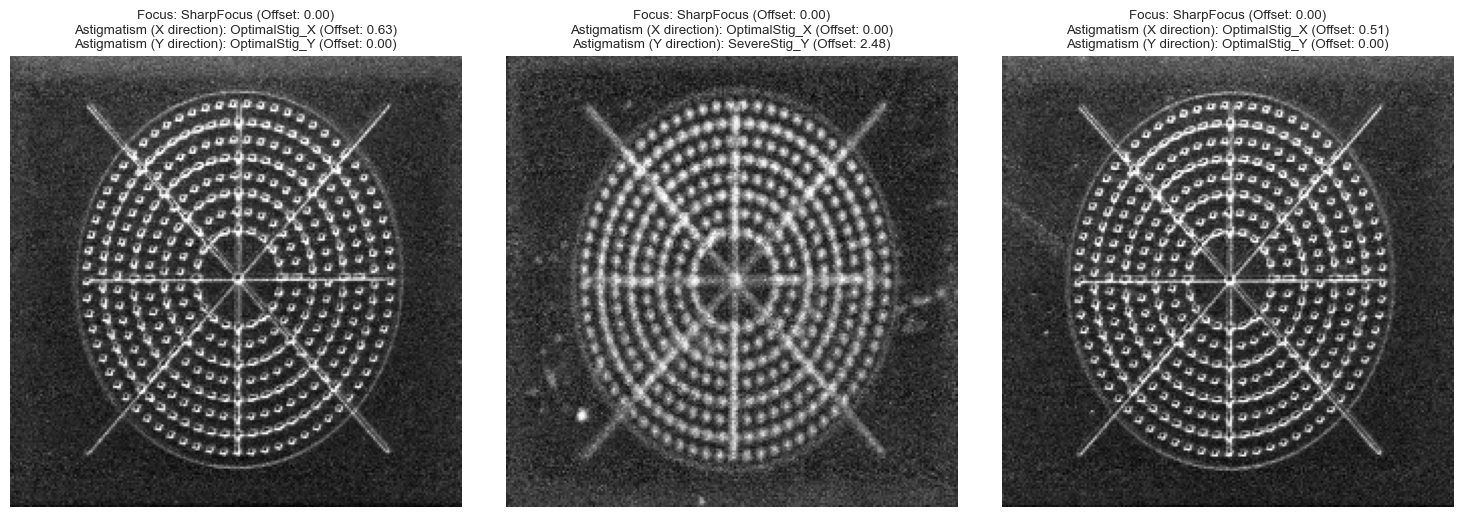

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def decode_labels(encoded_labels, label_encoders):
    """
    Decode the integer encoded labels back to their string representation using the label_encoders.
    
    Parameters:
    - encoded_labels: A list of integer encoded labels for a sample.
    - label_encoders: A dictionary containing the label encoders for each label.
    
    Returns:
    - A list of decoded label strings.
    """
    decoded = []
    for label, value in zip(label_encoders.keys(), encoded_labels):
        decoded_label = label_encoders[label].inverse_transform([value])[0]
        
        # Simplify the label values for better readability
        simple_mappings = {
            'SharpFocus': 'Optimal',
            'SlightlyBlurred': 'Moderate',
            'HighlyBlurred': 'Severe',
            'OptimalStig_X': 'Optimal',
            'ModerateStig_X': 'Moderate',
            'SevereStig_X': 'Severe',
            'OptimalStig_Y': 'Optimal',
            'ModerateStig_Y': 'Moderate',
            'SevereStig_Y': 'Severe'
        }
        
        # decoded_label = simple_mappings.get(decoded_label, decoded_label)
        decoded.append(decoded_label)
    return decoded

# Load a batch of test images, labels, and offsets
# test_images, test_labels_list, test_offsets = next(iter(test_dataset.take(1)))
test_images, test_labels_list = next(iter(test_dataset.take(1)))
test_labels_array = np.stack([np.array(label) for label in test_labels_list])

# Decode the labels of the first few samples
decoded_labels = [decode_labels(labels, label_encoders) for labels in test_labels_array]

# Display the images along with their decoded labels and offset values
num_samples_to_display = 3
fig, axes = plt.subplots(1, num_samples_to_display, figsize=(15, 5))
for img, labels, offset, ax in zip(test_images[:num_samples_to_display], 
                                   decoded_labels[:num_samples_to_display], 
                                   test_offsets[:num_samples_to_display], 
                                   axes):
    ax.imshow(img.numpy())  # Make sure to convert the tensor to numpy array
    
    # Improved wording and format for the title
    formatted_title = []
    for label, off, key in zip(labels, offset.numpy(), label_encoders.keys()):
        key = key.replace("_Label", "").replace("StigX", "Astigmatism (X direction)").replace("StigY", "Astigmatism (Y direction)")
        formatted_title.append(f"{key}: {label} (Offset: {off:.2f})")
    
    ax.set_title("\n".join(formatted_title))
    ax.axis('off')
plt.tight_layout()
plt.show()



In [ ]:
# Sample input
sample_input = test_images

# Initialize a dictionary to store the outputs
model_outputs = {}

# Iterate over each model and capture its output
for i, model in enumerate(all_best_models):
    
    # Check if the current model is actually a string or not a model object
    if isinstance(model, str) or not hasattr(model, 'predict'):
        print(f"Model_{i} is not a valid model. It's a: {type(model)} with value: {model}")
        continue
    
    # Debug: Print model name and its expected input shape (only if it has this attribute)
    if hasattr(model, 'input_shape'):
        print(f"Model_{i} expects input shape: {model.input_shape}")
    
    # Predict using the model
    output = model.predict(sample_input)
    
    # Debug: Print the type of the output
    print(f"Model_{i} produced output of type: {type(output)}")
    
    # If the output is a TensorFlow tensor, convert it to numpy
    if hasattr(output, 'numpy'):
        output = output.numpy()
    
    # Store the output in the dictionary
    model_outputs[f"Model_{i}"] = {
        "Output Shape": output.shape,
        "Output Type": type(output),
        "Sample Output": output[0] if len(output) > 0 else "No Output"
    }

# Print the model outputs
print(model_outputs)


Model_0 is not a valid model. It's a: <class 'str'> with value: SIM_Unbalanced_mobilenetv2
Model_1 is not a valid model. It's a: <class 'str'> with value: SIM_Unbalanced_inceptionv3
Model_2 is not a valid model. It's a: <class 'str'> with value: SIM_Unbalanced_resnet50
Model_3 is not a valid model. It's a: <class 'str'> with value: SIM_Unbalanced_small_xception
Model_4 is not a valid model. It's a: <class 'str'> with value: SIM_Unbalanced_basic_cnn
{}


In [ ]:
import pandas as pd

# Decode the labels for all samples in the batch (or a subset)
decoded_labels = [decode_labels(labels, label_encoders) for labels in test_labels_array]

# Extract the offsets and convert them to a list
offsets_list = [list(offset.numpy()) for offset in test_offsets]

# Prepare the data for the DataFrame
data = []
for labels, offset in zip(decoded_labels, offsets_list):
    row_data = []
    for label, off, key in zip(labels, offset, label_encoders.keys()):
        key = key.replace("_Label", "").replace("StigX", "Astigmatism (X direction)").replace("StigY", "Astigmatism (Y direction)")
        row_data.append(f"{label} (Offset: {off:.2f})")
    data.append(row_data)

# Create a DataFrame and display it
columns = [key.replace("_Label", "").replace("StigX", "Astigmatism (X direction)").replace("StigY", "Astigmatism (Y direction)") for key in label_encoders.keys()]
df = pd.DataFrame(data, columns=columns)

# print(df)


# Use the style method for a nicer display
styled_df = df.style.set_table_styles(
    [
        {"selector": "th", "props": [("font-size", "100%"), ("text-align", "center")]},
        {"selector": "td", "props": [("font-size", "100%"), ("text-align", "center")]}
    ]
)
styled_df

,Focus,Astigmatism (X direction),Astigmatism (Y direction)
0,SharpFocus (Offset: 0.00),OptimalStig_X (Offset: 0.63),OptimalStig_Y (Offset: 0.00)
1,SharpFocus (Offset: 0.00),OptimalStig_X (Offset: 0.00),SevereStig_Y (Offset: 2.48)
2,SharpFocus (Offset: 0.00),OptimalStig_X (Offset: 0.51),OptimalStig_Y (Offset: 0.00)
3,SharpFocus (Offset: 0.00),ModerateStig_X (Offset: -1.21),OptimalStig_Y (Offset: 0.00)
4,HighlyBlurred (Offset: 126.36),OptimalStig_X (Offset: 0.97),OptimalStig_Y (Offset: 0.68)
5,SharpFocus (Offset: 0.00),OptimalStig_X (Offset: 0.00),OptimalStig_Y (Offset: -0.28)
6,SlightlyBlurred (Offset: 37.82),OptimalStig_X (Offset: -0.17),OptimalStig_Y (Offset: 0.17)
7,SharpFocus (Offset: 0.00),OptimalStig_X (Offset: -0.26),OptimalStig_Y (Offset: 0.00)
8,SharpFocus (Offset: 0.00),OptimalStig_X (Offset: 0.00),ModerateStig_Y (Offset: 1.61)
9,SharpFocus (Offset: 0.00),ModerateStig_X (Offset: -1.38),OptimalStig_Y (Offset: 0.00)


In [ ]:
import numpy as np

# Placeholder for the available models
models = [
    'SIM_Unbalanced_mobilenetv2',
    'SIM_Unbalanced_inceptionv3',
    'SIM_Unbalanced_resnet50',
    'SIM_Unbalanced_small_xception',
    'SIM_Unbalanced_basic_cnn'
]


# Function to determine dataset structure
def determine_dataset_structure(test_dataset):
    # Check the length of a single item in the dataset
    single_item = next(iter(test_dataset))
    if isinstance(single_item, tuple) and len(single_item) == 2:
        return "Two elements per item (images and labels)"
    elif isinstance(single_item, tuple) and len(single_item) == 3:
        return "Three elements per item (images, labels, and additional data)"
    else:
        return "Unknown structure"

# Determine the dataset structure
dataset_structure = determine_dataset_structure(test_dataset)
dataset_structure


In [ ]:
# Assuming you have the model loading code available, we'll use a placeholder function for demonstration.

# Placeholder function to load the 'SIM_Unbalanced_mobilenetv2' model and make predictions
def load_mobilenetv2_model_and_predict(test_images):
    # Replace this with your actual code to load the model
    # Example:
    # from tensorflow.keras.applications import MobileNetV2
    # model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    
    # For the purpose of this demonstration, we'll use a random prediction as a placeholder
    num_samples = len(test_images)
    predictions = []
    for _ in range(num_samples):
        # Generate random prediction probabilities for three classes
        prediction_probabilities = np.random.rand(3)
        predictions.append(prediction_probabilities)
    
    return predictions

# Load the 'SIM_Unbalanced_mobilenetv2' model and make predictions
mobilenetv2_predictions = load_mobilenetv2_model_and_predict(test_images)

# Let's print the predictions for the first sample
print("Predictions for the first sample:")
print(mobilenetv2_predictions[0])


In [ ]:
import matplotlib.pyplot as plt

# Function to create a visualization for predictions
def visualize_predictions(test_images, true_labels, predicted_labels, probabilities):
    # Create a plot with subplots for each sample
    fig, axes = plt.subplots(1, 1, figsize=(8, 8))
    
    # Get the first sample
    sample_image = test_images[0]
    sample_true_labels = true_labels[0]  # Access individual elements
    sample_predicted_labels = predicted_labels[0]
    sample_probabilities = probabilities[0]
    
    # Display the test image
    axes.imshow(sample_image)
    axes.set_title("Sample Image")
    
    # Create labels for true and predicted classes
    true_label_names = ['Class 0', 'Class 1', 'Class 2']
    true_class = true_label_names[sample_true_labels[0]]  # Access the first element
    predicted_class = true_label_names[sample_predicted_labels]
    
    # Display true labels
    axes.text(10, 220, f"True Label: {true_class}", fontsize=12, color='green')
    
    # Display predicted labels and probabilities
    for i, (predicted_prob, label_name) in enumerate(zip(sample_probabilities, true_label_names)):
        axes.text(10, 190 - i * 20, f"Predicted {label_name}: {predicted_prob:.2f}", fontsize=12, color='blue')
    
    plt.axis('off')
    plt.show()

# Visualize predictions for the first sample
visualize_predictions(test_images, test_labels_list, [np.argmax(mobilenetv2_predictions[0])], mobilenetv2_predictions)


In [ ]:
# Works for Single Label Stuff

# import matplotlib.pyplot as plt
# import numpy as np

# def get_predictions(model, test_images):
#     """
#     Get predictions and prediction probabilities from the model.
#     Assumes binary/multi-class classification using softmax activation in the output layer.
#     """
#     probabilities = model.predict(test_images)
#     predictions = np.argmax(probabilities, axis=1)
#     return predictions, probabilities

# # Define number of test samples to display
# num_samples = 5  # You can adjust this value

# # Extract test images (assuming test_dataset structure is [test_images, test_labels, test_offsets])
# test_images, _, _ = next(iter(test_dataset.take(num_samples)))

# # Create 2D grid for visualization
# num_models = len(all_best_models)
# fig, axes = plt.subplots(num_models, num_samples, figsize=(15, 5 * num_models))

# for model_idx, model_name in enumerate(all_best_models.keys()):
#     model = all_best_models[model_name]
#     predictions, probabilities = get_predictions(model, test_images)
    
#     for sample_idx in range(num_samples):
#         ax = axes[model_idx, sample_idx]
#         ax.imshow(test_images[sample_idx].numpy())
        
#         predicted_label = label_encoders['Focus_Label'].inverse_transform([predictions[sample_idx]])[0]
#         prediction_prob = np.max(probabilities[sample_idx])
        
#         title = f"Model: {model_name}\nPredicted: {predicted_label}\nProbability: {prediction_prob:.2f}"
#         ax.set_title(title)
#         ax.axis('off')

# plt.tight_layout()
# plt.show()


In [ ]:
def get_multi_output_predictions(model, test_images):
    """
    Get predictions and prediction probabilities for a multi-output model.
    Assumes three outputs with softmax activation.
    """
    probabilities_list = model.predict(test_images)
    predictions_list = []

    for probs in probabilities_list:
        if len(probs.shape) == 1:  # If the probability output is 1D
            predictions_list.append(np.argmax(probs, axis=0))
        else:  # If the probability output is 2D
            predictions_list.append(np.argmax(probs, axis=1))
    
    return predictions_list, probabilities_list


import matplotlib.pyplot as plt

def visualize_predictions(test_images, true_labels_list, predictions_list, probabilities_list):
    num_samples, num_tasks = len(test_images), len(true_labels_list)
    
    fig, axes = plt.subplots(num_samples, num_tasks, figsize=(15, 5 * num_samples))

    for sample_idx in range(num_samples):
        for task_idx in range(num_tasks):
            ax = axes[sample_idx, task_idx]
            ax.imshow(test_images[sample_idx].numpy())

            true_label = true_labels_list[task_idx][sample_idx]
            predicted_label = predictions_list[task_idx][sample_idx]
            prediction_prob = np.max(probabilities_list[task_idx][sample_idx])

            title = f"True: {true_label}\nPredicted: {predicted_label}\nProbability: {prediction_prob:.2f}"
            ax.set_title(title)
            ax.axis('off')

    plt.tight_layout()
    plt.show()

test_images, test_labels_list, test_offsets = next(iter(test_dataset.take(5)))  # Adjust as per your dataset structure
predictions_list, probabilities_list = get_multi_output_predictions(model, test_images)
visualize_predictions(test_images, test_labels_list, predictions_list, probabilities_list)


In [ ]:
if num_elements == 2:
    test_images, test_labels_list = next(iter(test_dataset.take(5)))
elif num_elements == 3:
    test_images, test_labels_list, additional_info = next(iter(test_dataset.take(5)))
# ... add more conditions as needed
else:
    print("Unexpected dataset structure.")


## Incorporate Later

In [ ]:
def display_labels_with_probabilities(decoded_labels, probabilities):
    """
    Construct display strings that combine decoded labels with their corresponding probabilities.
    
    Parameters:
    - decoded_labels: A list of decoded label strings.
    - probabilities: A list of probability values corresponding to the decoded labels.
    
    Returns:
    - A list of strings combining labels with their probabilities.
    """
    return [f"{label} ({prob:.2f})" for label, prob in zip(decoded_labels, list(probabilities))]

# Load a batch of test images and labels
test_images, test_labels_list = next(iter(test_dataset.take(1)))
test_labels_array = np.stack([np.array(label) for label in test_labels_list])

# Make predictions using the selected model
predictions = model.predict(test_images)

# Decode the labels of the first few samples
decoded_labels = [decode_labels(labels, label_encoders) for labels in test_labels_array]
# Extract probabilities for the predicted labels
predicted_probs = [predictions[i][np.argmax(predictions[i])] for i in range(predictions.shape[0])]
display_strings = [display_labels_with_probabilities(labels, probs) for labels, probs in zip(decoded_labels, predicted_probs)]

# Display the images along with their decoded labels and probabilities
num_samples_to_display = 3
fig, axes = plt.subplots(1, num_samples_to_display, figsize=(15, 5))
for img, labels_with_probs, ax in zip(test_images[:num_samples_to_display], display_strings[:num_samples_to_display], axes):
    ax.imshow(img)
    title = "\n".join(labels_with_probs)
    ax.set_title(title)
    ax.axis('off')
plt.tight_layout()
plt.show()


In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_labels, pred_classes))

The classification_report() outputs the precision, recall and f1-score's per class.

A reminder:

Precision - Proportion of true positives over total number of samples. Higher precision leads to less false positives (model predicts 1 when it should've been 0).
Recall - Proportion of true positives over total number of true positives and false negatives (model predicts 0 when it should've been 1). Higher recall leads to less false negatives.
F1 score - Combines precision and recall into one metric. 1 is best, 0 is worst.
The above output is helpful but with so many classes, it's a bit hard to understand.

Let's see if we make it easier with the help of a visualization.

First, we'll get the output of classification_report() as a dictionary by setting output_dict=True.

In [ ]:
# Get a dictionary of the classification report
classification_report_dict = classification_report(y_labels, pred_classes, output_dict=True)
classification_report_dict

Alright, there's still a fair few values here, how about we narrow down?

Since the f1-score combines precision and recall in one metric, let's focus on that.

To extract it, we'll create an empty dictionary called class_f1_scores and then loop through each item in classification_report_dict, appending the class name and f1-score as the key, value pairs in class_f1_scores.

In [ ]:
# Create empty dictionary
class_f1_scores = {}
# Loop through classification report items
for k, v in classification_report_dict.items():
  if k == "accuracy": # stop once we get to accuracy key
    break
  else:
    # Append class names and f1-scores to new dictionary
    class_f1_scores[class_names[int(k)]] = v["f1-score"]
class_f1_scores

Looking good!

It seems like our dictionary is ordered by the class names. However, I think if we're trying to visualize different scores, it might look nicer if they were in some kind of order.

How about we turn our class_f1_scores dictionary into a pandas DataFrame and sort it in ascending fashion?

In [ ]:
# Turn f1-scores into dataframe for visualization
import pandas as pd
f1_scores = pd.DataFrame({"class_name": list(class_f1_scores.keys()),
                          "f1-score": list(class_f1_scores.values())}).sort_values("f1-score", ascending=False)
f1_scores.head()
     

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 25))
scores = ax.barh(range(len(f1_scores)), f1_scores["f1-score"].values)
ax.set_yticks(range(len(f1_scores)))
ax.set_yticklabels(list(f1_scores["class_name"]))
ax.set_xlabel("f1-score")
ax.set_title("F1-Scores for 10 Different Classes")
ax.invert_yaxis(); # reverse the order

def autolabel(rects): # Modified version of: https://matplotlib.org/examples/api/barchart_demo.html
  """
  Attach a text label above each bar displaying its height (it's value).
  """
  for rect in rects:
    width = rect.get_width()
    ax.text(1.03*width, rect.get_y() + rect.get_height()/1.5,
            f"{width:.2f}",
            ha='center', va='bottom')

autolabel(scores)

Finding the most wrong predictions
It's a good idea to go through at least 100+ random instances of your model's predictions to get a good feel for how it's doing.

After a while you might notice the model predicting on some images with a very high prediction probability, meaning it's very confident with its prediction but still getting the label wrong.

These most wrong predictions can help to give further insight into your model's performance.

So how about we write some code to collect all of the predictions where the model has output a high prediction probability for an image (e.g. 0.95+) but gotten the prediction wrong.

We'll go through the following steps:

Get all of the image file paths in the test dataset using the list_files() method.
Create a pandas DataFrame of the image filepaths, ground truth labels, prediction classes, max prediction probabilities, ground truth class names and predicted class names.
Note: We don't necessarily have to create a DataFrame like this but it'll help us visualize things as we go.
Use our DataFrame to find all the wrong predictions (where the ground truth doesn't match the prediction).
Sort the DataFrame based on wrong predictions and highest max prediction probabilities.
Visualize the images with the highest prediction probabilities but have the wrong prediction.

In [ ]:
# 1. Get the filenames of all of our test data
filepaths = []
for filepath in test_data.list_files("101_food_classes_10_percent/test/*/*.jpg", 
                                     shuffle=False):
  filepaths.append(filepath.numpy())
filepaths[:10]

Now we've got all of the test image filepaths, let's combine them into a DataFrame along with:

Their ground truth labels (y_labels).
The class the model predicted (pred_classes).
The maximum prediction probabilitity value (pred_probs.max(axis=1)).
The ground truth class names.
The predicted class names.

In [ ]:
# 2. Create a dataframe out of current prediction data for analysis
import pandas as pd
pred_df = pd.DataFrame({"img_path": filepaths,
                        "y_true": y_labels,
                        "y_pred": pred_classes,
                        "pred_conf": pred_probs.max(axis=1), # get the maximum prediction probability value
                        "y_true_classname": [class_names[i] for i in y_labels],
                        "y_pred_classname": [class_names[i] for i in pred_classes]}) 
pred_df.head()


# 3. Is the prediction correct?
pred_df["pred_correct"] = pred_df["y_true"] == pred_df["y_pred"]
pred_df.head()


# 4. Get the top 100 wrong examples
top_100_wrong = pred_df[pred_df["pred_correct"] == False].sort_values("pred_conf", ascending=False)[:100]
top_100_wrong.head(20)


# 5. Visualize some of the most wrong examples
images_to_view = 9
start_index = 10 # change the start index to view more
plt.figure(figsize=(15, 10))
for i, row in enumerate(top_100_wrong[start_index:start_index+images_to_view].itertuples()): 
  plt.subplot(3, 3, i+1)
  img = load_and_prep_image(row[1], scale=True)
  _, _, _, _, pred_prob, y_true, y_pred, _ = row # only interested in a few parameters of each row
  plt.imshow(img)
  plt.title(f"actual: {y_true}, pred: {y_pred} \nprob: {pred_prob:.2f}")
  plt.axis(False